In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vol_spike_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,1.023843,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,0.576864,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,0.443475,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,0.311600,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,0.282936,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,0.331950,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,0.237621,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,0.269923,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,4.429807,147.712062


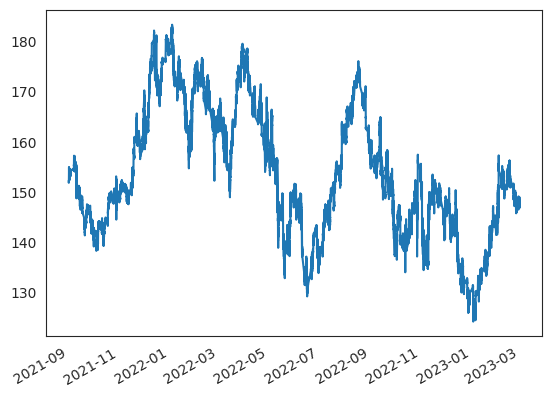

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_vol_spike_tick,
    params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
# # propose adjusted parameters ranges for next optuna run

# new_ranges = opts.propose_ranges_from_top(
#     csv_path="optuna_results/AAPL_13388051396.1535_target.csv",
#     top_n=25,
#     spread=10.0,
#     agg="median",
#     cat_top_k=3,
# )

# new_ranges

In [5]:
prun_perc       = 80
report_interval = 50

def objective(trial: optuna.Trial) -> float:
    
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.01, 0.05)      # median ~0.12
    max_down_prop   = trial.suggest_float("max_down_prop", 0.005, 0.02)     # median ~0.12
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.04, 0.07)   # median ~0.033
    tau_time        = trial.suggest_float("tau_time", 13.0, 17.0)          # median ~25.4 (narrow)
    tau_dur         = trial.suggest_float("tau_dur", 11.0, 19.0)          # median ~45, allow wider spread
    
    thresh_mode     = trial.suggest_categorical("thresh_mode",
                           ["median_nonzero"])
    thresh_window   = (trial.suggest_int("thresh_window", 10, 100)
                       if "roll" in thresh_mode else None)
    
    # --- Trading params (tighter) ---
    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 0, 9)            # median ~9
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 40), 90)          # median ~89
    
    vol_thresh     = trial.suggest_float("vol_thresh", 0.05, 0.2)         # median ~0.35
    adx_thresh     = trial.suggest_float("adx_thresh", 7, 13)          # median ~10.5
    atr_mult       = trial.suggest_float("atr_mult", 0.4, 1.1)             # median ~1.4–1.6
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -5, -1)       # many good trials negative; allow some positive
    buy_factor     = trial.suggest_float("buy_factor", 0.05, 0.13)         # median ~0.45
    sell_factor    = trial.suggest_float("sell_factor", 0.05, 0.13)        # median ~0.05–0.10
    trailstop_pct  = trial.suggest_float("trailstop_pct", 8, 20)        # median ~3.0

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # Build signals for this trial
    df = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
    )

    # Group per-day for this trial
    groups_list = list(df.groupby(df.index.normalize()))

    # Reset globals
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups_list, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = "signal_raw",
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_vol_spike   = params.col_vol_spike_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            # sess_start      = params.sess_premark,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess



Baseline mean daily B&H: -9.5162


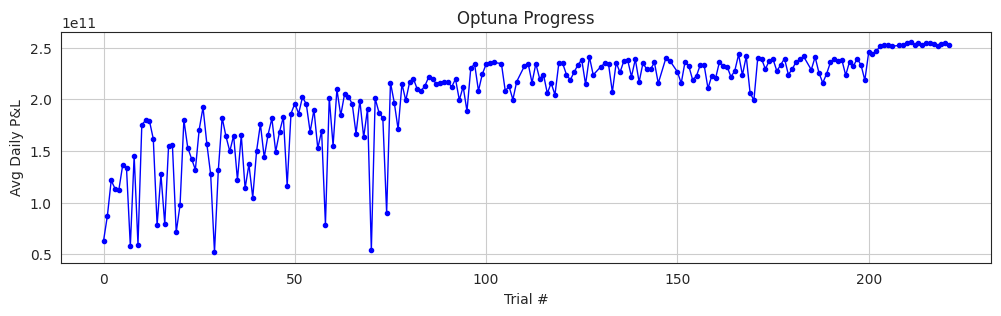

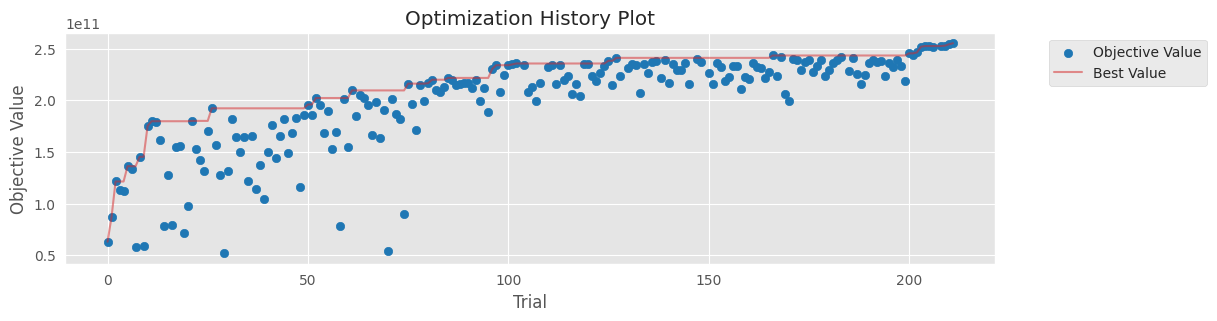

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04065927425248784; max_down_prop=0.010460775898347985; gain_tightfact=0.04497406279247944; tau_time=16.76708626781967; tau_dur=12.331068405656353; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=57; vol_thresh=0.07276907370882636; adx_thresh=8.31457911035323; atr_mult=0.4410477384708385; vwap_atr_mult=-2.8109663446190627; buy_factor=0.07329730329840202; sell_factor=0.06214390266913155; trailstop_pct=10.980326697824182


Trial 0: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:63112026995.8684 mean_bh:-8.7491 mean_excess:63112027004.6174 improv_vs_bh:721355274612.36%
Action counts: {'Buy': 40505, 'Sell': 64261, 'Hold': 245945}
Best trial is: 0 with best_val: 63112027004.6174
[save_results] wrote optuna_results/AAPL_63112027004.6174_target.csv
[save_best_json] wrote optuna_results/AAPL_63112027004.6174_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03672568670504666; max_down_prop=0.017117586629798405; gain_tightfact=0.061372947625018964; tau_time=14.400240706554051; tau_dur=18.880932931399858; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=68; vol_thresh=0.19206048750284005; adx_thresh=12.9689364479562; atr_mult=1.0847785852234253; vwap_atr_mult=-2.151334091187902; buy_factor=0.07130130333501628; sell_factor=0.11149807559233013; trailstop_pct=11.63486536935219

Trial 1: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]
/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


[Results] mean_pnl:87155581467.2764 mean_bh:-8.7491 mean_excess:87155581476.0255 improv_vs_bh:996167313799.61%
Action counts: {'Buy': 38010, 'Sell': 60971, 'Hold': 251730}
Best trial is: 1 with best_val: 87155581476.0255
[save_results] wrote optuna_results/AAPL_87155581476.0255_target.csv
[save_best_json] wrote optuna_results/AAPL_87155581476.0255_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014881795210376306; max_down_prop=0.010703630489942183; gain_tightfact=0.04783029136334732; tau_time=14.235483391005468; tau_dur=14.882188775770224; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=82; vol_thresh=0.07512059713223393; adx_thresh=9.474361043703738; atr_mult=0.650796159176019; vwap_atr_mult=-1.8746016421457101; buy_factor=0.10326373656401366; sell_factor=0.0667342761863883; trailstop_pct=19.48349628865175

Trial 2: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:121416774551.4933 mean_bh:-8.7491 mean_excess:121416774560.2423 improv_vs_bh:1387764502462.30%
Action counts: {'Buy': 41954, 'Sell': 66395, 'Hold': 242362}
Best trial is: 2 with best_val: 121416774560.2423
[save_results] wrote optuna_results/AAPL_121416774560.2423_target.csv
[save_best_json] wrote optuna_results/AAPL_121416774560.2423_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04749288704147032; max_down_prop=0.018356313662664124; gain_tightfact=0.041860676995133406; tau_time=14.583070500892163; tau_dur=13.501559421081193; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=45; vol_thresh=0.153700574982305; adx_thresh=8.115928828505345; atr_mult=0.916013451751335; vwap_atr_mult=-1.5180030695814897; buy_factor=0.07760246231897709; sell_factor=0.06075679983348274; trailstop_pct=19.637624865396887


Trial 3: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:113584313845.0834 mean_bh:-8.7491 mean_excess:113584313853.8325 improv_vs_bh:1298241362231.85%
Action counts: {'Buy': 36514, 'Sell': 61627, 'Hold': 252570}
Best trial is: 2 with best_val: 121416774560.2423
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018423241128404762; max_down_prop=0.007593937382063511; gain_tightfact=0.06761030601878244; tau_time=14.593179574382741; tau_dur=16.4515149105464; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=47; vol_thresh=0.0570767800508904; adx_thresh=7.251091332772604; atr_mult=0.4993486647647357; vwap_atr_mult=-3.027645554402074; buy_factor=0.05758216564371205; sell_factor=0.10898764458667062; trailstop_pct=8.680273271967447


Trial 4: 100%|██████████| 375/375 [00:35<00:00, 10.46it/s]


[Results] mean_pnl:112307859994.8975 mean_bh:-8.7491 mean_excess:112307860003.6466 improv_vs_bh:1283651802027.05%
Action counts: {'Buy': 39343, 'Sell': 65821, 'Hold': 245547}
Best trial is: 2 with best_val: 121416774560.2423
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.045685408963507666; max_down_prop=0.012844966808523609; gain_tightfact=0.06840557208514415; tau_time=13.96893896487675; tau_dur=13.2674879300001; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=61; vol_thresh=0.09689253311771516; adx_thresh=10.37057920770583; atr_mult=0.8142067953038425; vwap_atr_mult=-4.775662659727587; buy_factor=0.07923579748034701; sell_factor=0.07665564429903284; trailstop_pct=12.725827606426739


Trial 5: 100%|██████████| 375/375 [00:39<00:00,  9.48it/s]
/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


[Results] mean_pnl:136223202977.4832 mean_bh:-8.7491 mean_excess:136223202986.2323 improv_vs_bh:1556998414763.63%
Action counts: {'Buy': 40568, 'Sell': 62286, 'Hold': 247857}
Best trial is: 5 with best_val: 136223202986.2323
[save_results] wrote optuna_results/AAPL_136223202986.2323_target.csv
[save_best_json] wrote optuna_results/AAPL_136223202986.2323_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0235537853128321; max_down_prop=0.015809377636600345; gain_tightfact=0.06309518280240276; tau_time=14.020861550256152; tau_dur=13.597584409254221; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=55; vol_thresh=0.06667213713904067; adx_thresh=7.413433359883868; atr_mult=1.04980206224879; vwap_atr_mult=-2.9382682955630366; buy_factor=0.11113142142364635; sell_factor=0.11373727638487724; trailstop_pct=19.0173969634

Trial 6: 100%|██████████| 375/375 [00:41<00:00,  9.04it/s]


[Results] mean_pnl:133327076498.8191 mean_bh:-8.7491 mean_excess:133327076507.5683 improv_vs_bh:1523896386347.14%
Action counts: {'Buy': 41130, 'Sell': 65466, 'Hold': 244115}
Best trial is: 5 with best_val: 136223202986.2323
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.034588248056765386; max_down_prop=0.010987692065023012; gain_tightfact=0.06269368805605227; tau_time=16.241305534895666; tau_dur=15.54329385222545; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=45; vol_thresh=0.11231083213145464; adx_thresh=10.97731606292659; atr_mult=0.43164669160055946; vwap_atr_mult=-2.435053460619833; buy_factor=0.09109427836528125; sell_factor=0.09611583767889642; trailstop_pct=19.545176671313932


Trial 7: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:57969041023.8147 mean_bh:-8.7491 mean_excess:57969041032.5638 improv_vs_bh:662572183111.80%
Action counts: {'Buy': 36767, 'Sell': 63189, 'Hold': 250755}
Best trial is: 5 with best_val: 136223202986.2323
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02197839849669838; max_down_prop=0.017602119548151957; gain_tightfact=0.06535221696512314; tau_time=13.738551242723803; tau_dur=18.218315227639387; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=44; vol_thresh=0.13252705446064045; adx_thresh=10.392286255780387; atr_mult=0.8711761181960846; vwap_atr_mult=-3.3674924251857856; buy_factor=0.0981713581100683; sell_factor=0.05638259292757832; trailstop_pct=17.891604763816062


Trial 8: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:145318222304.9079 mean_bh:-8.7491 mean_excess:145318222313.6570 improv_vs_bh:1660952296074.70%
Action counts: {'Buy': 37904, 'Sell': 65452, 'Hold': 247355}
Best trial is: 8 with best_val: 145318222313.6570
[save_results] wrote optuna_results/AAPL_145318222313.657_target.csv
[save_best_json] wrote optuna_results/AAPL_145318222313.657_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04246903169030324; max_down_prop=0.007550565529635889; gain_tightfact=0.04554989672453649; tau_time=16.463763946022908; tau_dur=15.66234703024201; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=49; vol_thresh=0.08677669972383059; adx_thresh=9.288207424792944; atr_mult=0.40663437304746064; vwap_atr_mult=-3.819992722418306; buy_factor=0.05443025051124232; sell_factor=0.09310770945312352; trailstop_pct=10.959145031696892


Trial 9: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:59405335026.6676 mean_bh:-8.7491 mean_excess:59405335035.4167 improv_vs_bh:678988677780.50%
Action counts: {'Buy': 38801, 'Sell': 62455, 'Hold': 249455}
Best trial is: 8 with best_val: 145318222313.6570
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.026980636985073816; max_down_prop=0.019645309069562546; gain_tightfact=0.05501703806187279; tau_time=13.089858963654013; tau_dur=18.86741867933216; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; vol_thresh=0.14506945451477593; adx_thresh=11.782675355968856; atr_mult=0.6958633692912184; vwap_atr_mult=-3.9633335612995984; buy_factor=0.1218636744798264; sell_factor=0.05107313498037301; trailstop_pct=16.421856098731624


Trial 10: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:175255649895.1306 mean_bh:-8.7491 mean_excess:175255649903.8797 improv_vs_bh:2003129886075.93%
Action counts: {'Buy': 40395, 'Sell': 66062, 'Hold': 244254}
Best trial is: 10 with best_val: 175255649903.8797
[save_results] wrote optuna_results/AAPL_175255649903.8797_target.csv
[save_best_json] wrote optuna_results/AAPL_175255649903.8797_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02693359277387134; max_down_prop=0.01940088470146769; gain_tightfact=0.053971689765368654; tau_time=13.025031485391528; tau_dur=18.665941817164452; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; vol_thresh=0.14401544142596384; adx_thresh=11.769188492202899; atr_mult=0.665881222470187; vwap_atr_mult=-3.969931528542079; buy_factor=0.12906307445689635; sell_factor=0.050493187869041674; trailstop_pct=16.20444577749039


Trial 11: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:179759304838.8612 mean_bh:-8.7491 mean_excess:179759304847.6104 improv_vs_bh:2054605577839.98%
Action counts: {'Buy': 40359, 'Sell': 66241, 'Hold': 244111}
Best trial is: 11 with best_val: 179759304847.6104
[save_results] wrote optuna_results/AAPL_179759304847.6104_target.csv
[save_best_json] wrote optuna_results/AAPL_179759304847.6104_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02826113821155202; max_down_prop=0.01960100415077154; gain_tightfact=0.05398978577608741; tau_time=13.00931400201348; tau_dur=17.730553547358458; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; vol_thresh=0.1605331863340697; adx_thresh=11.949693093910899; atr_mult=0.6560737003852897; vwap_atr_mult=-4.281989792044127; buy_factor=0.1280953378141648; sell_factor=0.05037854909684138; trailstop_pct=16.302325951149275


Trial 12: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:179067428554.6916 mean_bh:-8.7491 mean_excess:179067428563.4407 improv_vs_bh:2046697598479.28%
Action counts: {'Buy': 40102, 'Sell': 65931, 'Hold': 244678}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.030985116954838906; max_down_prop=0.015015906111743322; gain_tightfact=0.054120967952295686; tau_time=13.074631902404844; tau_dur=17.270627846055714; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; vol_thresh=0.1774754083386325; adx_thresh=12.352718078461468; atr_mult=0.5948406927997806; vwap_atr_mult=-4.811752544710621; buy_factor=0.12913346667437822; sell_factor=0.07699675616509791; trailstop_pct=15.566464706127825


Trial 13: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:161721790613.2363 mean_bh:-8.7491 mean_excess:161721790621.9854 improv_vs_bh:1848441132724.03%
Action counts: {'Buy': 39751, 'Sell': 65169, 'Hold': 245791}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.030445447119514624; max_down_prop=0.019904033026445025; gain_tightfact=0.05370685060349196; tau_time=15.28811845919427; tau_dur=17.604849233637562; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=76; vol_thresh=0.1651014516208963; adx_thresh=11.485153550227936; atr_mult=0.5737483139666028; vwap_atr_mult=-4.147199678277904; buy_factor=0.11701183884185413; sell_factor=0.07488612699133873; trailstop_pct=14.807389619371621


Trial 14: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:78457608362.3693 mean_bh:-8.7491 mean_excess:78457608371.1184 improv_vs_bh:896751575224.11%
Action counts: {'Buy': 39925, 'Sell': 64492, 'Hold': 246294}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010789032820693014; max_down_prop=0.014583271433952338; gain_tightfact=0.05012783742150712; tau_time=13.440081232604783; tau_dur=17.067845138226396; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; vol_thresh=0.12396323447246241; adx_thresh=12.841892888168626; atr_mult=0.7527146288389773; vwap_atr_mult=-4.3664660430948175; buy_factor=0.12833426212712012; sell_factor=0.12651638086095993; trailstop_pct=16.812914413421247


Trial 15: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:127281502527.3155 mean_bh:-8.7491 mean_excess:127281502536.0645 improv_vs_bh:1454796931308.50%
Action counts: {'Buy': 39912, 'Sell': 64922, 'Hold': 245877}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.025428163920933482; max_down_prop=0.01657240960103478; gain_tightfact=0.05777619200994201; tau_time=15.36861565358156; tau_dur=11.206033579935898; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=67; vol_thresh=0.17489865822184716; adx_thresh=11.850839538984149; atr_mult=0.7402921075361157; vwap_atr_mult=-3.571917372247871; buy_factor=0.11169608222790084; sell_factor=0.05025223901584101; trailstop_pct=13.347517120710744


Trial 16: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:79436058177.6304 mean_bh:-8.7491 mean_excess:79436058186.3795 improv_vs_bh:907935021053.38%
Action counts: {'Buy': 39509, 'Sell': 64948, 'Hold': 246254}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.035010419873786336; max_down_prop=0.0055800412317795044; gain_tightfact=0.05873787334467078; tau_time=13.494932926812446; tau_dur=17.888613191407526; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=75; vol_thresh=0.1996875683817291; adx_thresh=11.004751575477933; atr_mult=0.6036599552083689; vwap_atr_mult=-4.495320461083504; buy_factor=0.12024137778946144; sell_factor=0.0701990863076852; trailstop_pct=17.503562673361913


Trial 17: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:155182650383.6611 mean_bh:-8.7491 mean_excess:155182650392.4102 improv_vs_bh:1773700334180.37%
Action counts: {'Buy': 40090, 'Sell': 64969, 'Hold': 245652}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018967737787290603; max_down_prop=0.013419088329133558; gain_tightfact=0.05146324944001807; tau_time=13.094712684894656; tau_dur=16.56421678223583; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=84; vol_thresh=0.14346761007415684; adx_thresh=12.348517225940048; atr_mult=0.9610066166185749; vwap_atr_mult=-3.4737921962380254; buy_factor=0.10507870937998134; sell_factor=0.08981960874609823; trailstop_pct=14.636349403478608


Trial 18: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:155590736309.8769 mean_bh:-8.7491 mean_excess:155590736318.6259 improv_vs_bh:1778364658071.43%
Action counts: {'Buy': 40080, 'Sell': 64869, 'Hold': 245762}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028635938660507055; max_down_prop=0.018618403151131335; gain_tightfact=0.05745582193339574; tau_time=15.78990537951447; tau_dur=18.3908977769036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=70; vol_thresh=0.12027152099340273; adx_thresh=10.990974455274195; atr_mult=0.5233450473228353; vwap_atr_mult=-4.375084655959996; buy_factor=0.0893108080914545; sell_factor=0.0866212985337659; trailstop_pct=15.823361639874516


Trial 19: 100%|██████████| 375/375 [00:35<00:00, 10.53it/s]


[Results] mean_pnl:71436098699.6081 mean_bh:-8.7491 mean_excess:71436098708.3572 improv_vs_bh:816497410188.27%
Action counts: {'Buy': 40487, 'Sell': 64641, 'Hold': 245583}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03211001514444184; max_down_prop=0.019857632248065603; gain_tightfact=0.05031005185373939; tau_time=14.91385189231945; tau_dur=14.719808549184739; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=62; vol_thresh=0.16486693226673557; adx_thresh=9.670294365387726; atr_mult=0.8027851394440265; vwap_atr_mult=-1.02277916178378; buy_factor=0.128530273388399; sell_factor=0.057366601261287536; trailstop_pct=17.74815189275401


Trial 20: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:97805819165.5342 mean_bh:-8.7491 mean_excess:97805819174.2833 improv_vs_bh:1117896966674.67%
Action counts: {'Buy': 40090, 'Sell': 65047, 'Hold': 245574}
Best trial is: 11 with best_val: 179759304847.6104
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.025919157444449944; max_down_prop=0.018969186783543677; gain_tightfact=0.05583620996247756; tau_time=13.038629531811148; tau_dur=18.980528671651857; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; vol_thresh=0.14298637156112007; adx_thresh=11.649704868427014; atr_mult=0.6917867372245385; vwap_atr_mult=-4.046931971943398; buy_factor=0.12209760443125751; sell_factor=0.050470100457156476; trailstop_pct=16.62267339048556


Trial 21: 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]


[Results] mean_pnl:180084506502.1254 mean_bh:-8.7491 mean_excess:180084506510.8744 improv_vs_bh:2058322554559.67%
Action counts: {'Buy': 40584, 'Sell': 66361, 'Hold': 243766}
Best trial is: 21 with best_val: 180084506510.8744
[save_results] wrote optuna_results/AAPL_180084506510.8744_target.csv
[save_best_json] wrote optuna_results/AAPL_180084506510.8744_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020831211326973107; max_down_prop=0.018017976683998044; gain_tightfact=0.05505858310610224; tau_time=13.342258834527133; tau_dur=18.771526498658694; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; vol_thresh=0.13794487010951087; adx_thresh=12.289658156978353; atr_mult=0.6631343393386349; vwap_atr_mult=-3.794877315078335; buy_factor=0.11982140873244713; sell_factor=0.05033561388934168; trailstop_pct=14.456917469326028


Trial 22: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:153294524084.6245 mean_bh:-8.7491 mean_excess:153294524093.3736 improv_vs_bh:1752119505143.70%
Action counts: {'Buy': 40146, 'Sell': 66162, 'Hold': 244403}
Best trial is: 21 with best_val: 180084506510.8744
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02544370680784657; max_down_prop=0.01629130177795948; gain_tightfact=0.05984772931580237; tau_time=13.645929817232235; tau_dur=17.955607208484803; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=72; vol_thresh=0.15634992882244206; adx_thresh=11.52447491680716; atr_mult=0.7611106248333142; vwap_atr_mult=-4.973005664699053; buy_factor=0.11160339705592197; sell_factor=0.06612310481344724; trailstop_pct=18.40257794253596


Trial 23: 100%|██████████| 375/375 [00:44<00:00,  8.50it/s]


[Results] mean_pnl:142600732201.3515 mean_bh:-8.7491 mean_excess:142600732210.1006 improv_vs_bh:1629892038419.47%
Action counts: {'Buy': 40389, 'Sell': 65580, 'Hold': 244742}
Best trial is: 21 with best_val: 180084506510.8744
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03811859725793101; max_down_prop=0.018793305860433804; gain_tightfact=0.053114560370060765; tau_time=13.811502374914598; tau_dur=16.676651285000748; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=79; vol_thresh=0.10583696198586849; adx_thresh=12.07471743284878; atr_mult=0.6940418260455181; vwap_atr_mult=-4.149791028444009; buy_factor=0.12376172732486831; sell_factor=0.05788805627674683; trailstop_pct=16.710122612049776


Trial 24: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:131849381450.0263 mean_bh:-8.7491 mean_excess:131849381458.7754 improv_vs_bh:1507006687690.54%
Action counts: {'Buy': 40286, 'Sell': 64093, 'Hold': 246332}
Best trial is: 21 with best_val: 180084506510.8744
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014913700416548721; max_down_prop=0.014115228292107956; gain_tightfact=0.05654855488792374; tau_time=13.284391291356137; tau_dur=17.431478230421334; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; vol_thresh=0.15208921918647486; adx_thresh=11.313459865858022; atr_mult=0.5333649972911902; vwap_atr_mult=-4.603460038563868; buy_factor=0.11487441339042101; sell_factor=0.05640425096034635; trailstop_pct=15.48615724592869


Trial 25: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:170741209794.6491 mean_bh:-8.7491 mean_excess:170741209803.3981 improv_vs_bh:1951530922566.72%
Action counts: {'Buy': 40972, 'Sell': 67371, 'Hold': 242368}
Best trial is: 21 with best_val: 180084506510.8744
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028079027373973872; max_down_prop=0.017422336473970464; gain_tightfact=0.04716548458388223; tau_time=13.003650040241217; tau_dur=18.99173890661863; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=64; vol_thresh=0.1329096236077884; adx_thresh=10.469832254375964; atr_mult=0.6731452132957847; vwap_atr_mult=-3.188959026687927; buy_factor=0.1047726214913476; sell_factor=0.07028684915542763; trailstop_pct=13.423169155245464


Trial 26: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:192266856591.1198 mean_bh:-8.7491 mean_excess:192266856599.8688 improv_vs_bh:2197563883208.92%
Action counts: {'Buy': 40732, 'Sell': 66088, 'Hold': 243891}
Best trial is: 26 with best_val: 192266856599.8688
[save_results] wrote optuna_results/AAPL_192266856599.8688_target.csv
[save_best_json] wrote optuna_results/AAPL_192266856599.8688_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03308225780496318; max_down_prop=0.015547214900016527; gain_tightfact=0.041153453443967786; tau_time=13.495442311777445; tau_dur=18.89721765804189; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=60; vol_thresh=0.13094216975529674; adx_thresh=10.379427980928392; atr_mult=0.8086703728800317; vwap_atr_mult=-3.2408005238788835; buy_factor=0.10323423562641497; sell_factor=0.08090910346987945; trailstop_pct=13.449865996346851


Trial 27: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:156979849819.9656 mean_bh:-8.7491 mean_excess:156979849828.7147 improv_vs_bh:1794241891066.41%
Action counts: {'Buy': 40411, 'Sell': 64843, 'Hold': 245457}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023355744409327313; max_down_prop=0.017172957933009544; gain_tightfact=0.04789376750141764; tau_time=14.106963462104197; tau_dur=18.338378401612903; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=65; vol_thresh=0.11785950945932891; adx_thresh=8.896883847143624; atr_mult=0.6252473060326929; vwap_atr_mult=-2.7080710491159206; buy_factor=0.09472559385346933; sell_factor=0.06873189055180758; trailstop_pct=12.006328208111409


Trial 28: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:127331015046.7248 mean_bh:-8.7491 mean_excess:127331015055.4739 improv_vs_bh:1455362847485.34%
Action counts: {'Buy': 41207, 'Sell': 66188, 'Hold': 243316}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017997457708394695; max_down_prop=0.01184964308372596; gain_tightfact=0.043639709956402525; tau_time=16.98467225217966; tau_dur=16.201324054271605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=52; vol_thresh=0.10545958981701517; adx_thresh=9.982647316778984; atr_mult=0.4852535374063567; vwap_atr_mult=-3.6568575094646927; buy_factor=0.10570577552657227; sell_factor=0.0639022696656461; trailstop_pct=10.10625207579185


Trial 29: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:51970122525.1812 mean_bh:-8.7491 mean_excess:51970122533.9303 improv_vs_bh:594005988895.88%
Action counts: {'Buy': 39383, 'Sell': 65606, 'Hold': 245722}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.040111449810664626; max_down_prop=0.01857107239754567; gain_tightfact=0.04736493627495482; tau_time=13.787826587158703; tau_dur=14.238400926496702; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=40; vol_thresh=0.1799183742498591; adx_thresh=10.690346153887976; atr_mult=0.7306631907498161; vwap_atr_mult=-3.1951485533079698; buy_factor=0.0854596013001605; sell_factor=0.07184481671617458; trailstop_pct=13.656958495588137


Trial 30: 100%|██████████| 375/375 [00:44<00:00,  8.42it/s]


[Results] mean_pnl:131514640080.9822 mean_bh:-8.7491 mean_excess:131514640089.7313 improv_vs_bh:1503180674430.45%
Action counts: {'Buy': 36031, 'Sell': 62740, 'Hold': 251940}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028234727226587025; max_down_prop=0.019192939053965047; gain_tightfact=0.05164307013920211; tau_time=13.023327114368975; tau_dur=18.31896402735263; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=71; vol_thresh=0.1432698788845804; adx_thresh=11.276001286332114; atr_mult=0.6898912525348196; vwap_atr_mult=-4.151951816660241; buy_factor=0.12425829757086383; sell_factor=0.06222891898717428; trailstop_pct=16.143852849839423


Trial 31: 100%|██████████| 375/375 [00:43<00:00,  8.68it/s]


[Results] mean_pnl:182259982896.4014 mean_bh:-8.7491 mean_excess:182259982905.1505 improv_vs_bh:2083187726006.16%
Action counts: {'Buy': 40594, 'Sell': 65998, 'Hold': 244119}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.026225715061876625; max_down_prop=0.017226561533150348; gain_tightfact=0.050397914978682616; tau_time=13.279198577141393; tau_dur=18.49907667817473; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=65; vol_thresh=0.14359383740270903; adx_thresh=11.266283439929701; atr_mult=0.7002849325524256; vwap_atr_mult=-3.9917211762148823; buy_factor=0.12358534092104421; sell_factor=0.06189122850032599; trailstop_pct=15.031940767454927


Trial 32: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:164124295219.3515 mean_bh:-8.7491 mean_excess:164124295228.1007 improv_vs_bh:1875901181975.42%
Action counts: {'Buy': 40515, 'Sell': 66158, 'Hold': 244038}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029496188177347678; max_down_prop=0.019204682014844363; gain_tightfact=0.051932824376381276; tau_time=13.242342283247051; tau_dur=18.992223292385216; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=69; vol_thresh=0.12622726063037434; adx_thresh=12.748032870173748; atr_mult=0.5635222696346072; vwap_atr_mult=-2.6636013265977936; buy_factor=0.11618945855359275; sell_factor=0.05523052445254532; trailstop_pct=17.123810139455028


Trial 33: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:149653235900.0209 mean_bh:-8.7491 mean_excess:149653235908.7700 improv_vs_bh:1710500457824.00%
Action counts: {'Buy': 39351, 'Sell': 64976, 'Hold': 246384}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024889758979121542; max_down_prop=0.017896300936225927; gain_tightfact=0.04872816762126386; tau_time=13.60628953520608; tau_dur=18.110817420027036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=71; vol_thresh=0.1359584332783309; adx_thresh=10.104809471441708; atr_mult=0.6256934368808499; vwap_atr_mult=-2.240803843787667; buy_factor=0.06621580735455912; sell_factor=0.0610135572003108; trailstop_pct=18.519036224901573


Trial 34: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:164903736112.4710 mean_bh:-8.7491 mean_excess:164903736121.2201 improv_vs_bh:1884810003735.48%
Action counts: {'Buy': 41270, 'Sell': 66519, 'Hold': 242922}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02756471678767848; max_down_prop=0.016388687634407068; gain_tightfact=0.044633023836460284; tau_time=14.240525866155167; tau_dur=16.972274456588938; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; vol_thresh=0.14988339704121417; adx_thresh=10.722424633269886; atr_mult=0.7795867752088675; vwap_atr_mult=-3.9312149585311915; buy_factor=0.10869366595419219; sell_factor=0.06439801802965392; trailstop_pct=12.765085062095386


Trial 35: 100%|██████████| 375/375 [00:37<00:00,  9.90it/s]


[Results] mean_pnl:121967488619.0319 mean_bh:-8.7491 mean_excess:121967488627.7810 improv_vs_bh:1394059031671.34%
Action counts: {'Buy': 40517, 'Sell': 65395, 'Hold': 244799}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021062095356816243; max_down_prop=0.018970333243468876; gain_tightfact=0.05186932301336941; tau_time=13.014955205109466; tau_dur=18.577773969041303; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; vol_thresh=0.1688886615652307; adx_thresh=11.652864413563087; atr_mult=0.854982986850069; vwap_atr_mult=-3.7293413424853616; buy_factor=0.12484720174538308; sell_factor=0.1001790752573824; trailstop_pct=14.1878992082048


Trial 36: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:165224966688.0114 mean_bh:-8.7491 mean_excess:165224966696.7605 improv_vs_bh:1888481591878.51%
Action counts: {'Buy': 39317, 'Sell': 65114, 'Hold': 246280}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04997515027506187; max_down_prop=0.017895881477952524; gain_tightfact=0.046325226147657245; tau_time=14.476134617031725; tau_dur=11.831798861282888; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=63; vol_thresh=0.1858949247047929; adx_thresh=10.687263004806919; atr_mult=0.6721210780591034; vwap_atr_mult=-1.8686070537446415; buy_factor=0.09927705829820826; sell_factor=0.08032529311489267; trailstop_pct=16.189679030251046


Trial 37: 100%|██████████| 375/375 [00:44<00:00,  8.39it/s]


[Results] mean_pnl:113821692119.0419 mean_bh:-8.7491 mean_excess:113821692127.7909 improv_vs_bh:1300954538755.01%
Action counts: {'Buy': 39276, 'Sell': 61358, 'Hold': 250077}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0334592501834481; max_down_prop=0.009258818804312407; gain_tightfact=0.0561576796891076; tau_time=13.89155948860376; tau_dur=17.82580576487666; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; vol_thresh=0.14040921371065604; adx_thresh=11.261079593622798; atr_mult=0.7211267226455996; vwap_atr_mult=-3.0508103145464665; buy_factor=0.11709181064856723; sell_factor=0.05396560443654316; trailstop_pct=15.469849929499022


Trial 38: 100%|██████████| 375/375 [00:53<00:00,  7.05it/s]


[Results] mean_pnl:137044212571.4600 mean_bh:-8.7491 mean_excess:137044212580.2091 improv_vs_bh:1566382356766.94%
Action counts: {'Buy': 40746, 'Sell': 65105, 'Hold': 244860}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.037138874564134; max_down_prop=0.01707368667329655; gain_tightfact=0.06077620819628944; tau_time=14.79386034860643; tau_dur=15.932780372960378; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=55; vol_thresh=0.1289542757236227; adx_thresh=8.525415214222486; atr_mult=0.6469470180988756; vwap_atr_mult=-4.654244760241495; buy_factor=0.12447924424201573; sell_factor=0.05989041874825199; trailstop_pct=12.75698474872124


Trial 39: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:104809831016.7271 mean_bh:-8.7491 mean_excess:104809831025.4762 improv_vs_bh:1197951135936.83%
Action counts: {'Buy': 40536, 'Sell': 65069, 'Hold': 245106}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02389586471721431; max_down_prop=0.01566782701144619; gain_tightfact=0.04292664842667742; tau_time=13.242852760418394; tau_dur=18.260678487506098; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=68; vol_thresh=0.1116935638369047; adx_thresh=12.543950217231135; atr_mult=0.8698151555601507; vwap_atr_mult=-3.3954890914708056; buy_factor=0.10853990298677182; sell_factor=0.06566112060418394; trailstop_pct=8.781948089761237


Trial 40: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]


[Results] mean_pnl:149862986785.0544 mean_bh:-8.7491 mean_excess:149862986793.8035 improv_vs_bh:1712897859942.97%
Action counts: {'Buy': 39873, 'Sell': 64984, 'Hold': 245854}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028900725814586407; max_down_prop=0.01922430451761206; gain_tightfact=0.049147165294762526; tau_time=13.027750932976865; tau_dur=17.637720546354586; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; vol_thresh=0.1573889633765037; adx_thresh=12.011990845496202; atr_mult=0.6466119603785687; vwap_atr_mult=-4.100767354027153; buy_factor=0.12986253632982986; sell_factor=0.05320896696801384; trailstop_pct=16.17131914563017


Trial 41: 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]


[Results] mean_pnl:176060072951.9173 mean_bh:-8.7491 mean_excess:176060072960.6664 improv_vs_bh:2012324247952.32%
Action counts: {'Buy': 40040, 'Sell': 65812, 'Hold': 244859}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027636238685372738; max_down_prop=0.019917895111465453; gain_tightfact=0.05304452394547922; tau_time=13.497423757683562; tau_dur=18.610016770600968; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; vol_thresh=0.1584106989915953; adx_thresh=12.158505949071058; atr_mult=0.6797788397812515; vwap_atr_mult=-4.2599067261026295; buy_factor=0.12639138689042376; sell_factor=0.053064390445758745; trailstop_pct=17.358142656878233


Trial 42: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:143714408258.9998 mean_bh:-8.7491 mean_excess:143714408267.7489 improv_vs_bh:1642621087643.88%
Action counts: {'Buy': 39947, 'Sell': 65437, 'Hold': 245327}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.031408695247629945; max_down_prop=0.01837989020608115; gain_tightfact=0.05530398964128145; tau_time=13.228846378785041; tau_dur=18.034251050367693; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=76; vol_thresh=0.15005222348318306; adx_thresh=11.838919989222463; atr_mult=0.6098671031974174; vwap_atr_mult=-4.422472054381686; buy_factor=0.11953847009684285; sell_factor=0.06021088933257763; trailstop_pct=18.43407552881586


Trial 43: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:165751516001.1307 mean_bh:-8.7491 mean_excess:165751516009.8798 improv_vs_bh:1894499923762.14%
Action counts: {'Buy': 40305, 'Sell': 65508, 'Hold': 244898}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03522899088160795; max_down_prop=0.019267482305486586; gain_tightfact=0.05902481154508245; tau_time=13.026705798419489; tau_dur=18.96442925552615; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; vol_thresh=0.16268902562169063; adx_thresh=11.13252266470547; atr_mult=0.5696768406364365; vwap_atr_mult=-4.81045260164905; buy_factor=0.12087497060680547; sell_factor=0.07247192951742798; trailstop_pct=14.027793370420772


Trial 44: 100%|██████████| 375/375 [00:41<00:00,  9.04it/s]


[Results] mean_pnl:181516283491.9896 mean_bh:-8.7491 mean_excess:181516283500.7387 improv_vs_bh:2074687420857.36%
Action counts: {'Buy': 40459, 'Sell': 65186, 'Hold': 245066}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03538257507445995; max_down_prop=0.017561036099810353; gain_tightfact=0.06274343937927557; tau_time=13.634396950588632; tau_dur=18.901221421470662; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=72; vol_thresh=0.14727404473208394; adx_thresh=9.993657379897334; atr_mult=0.5805383618757362; vwap_atr_mult=-4.915422583730449; buy_factor=0.11370469597233224; sell_factor=0.0732687581632767; trailstop_pct=11.045582801283798


Trial 45: 100%|██████████| 375/375 [00:38<00:00,  9.87it/s]


[Results] mean_pnl:149354965115.3828 mean_bh:-8.7491 mean_excess:149354965124.1319 improv_vs_bh:1707091294563.48%
Action counts: {'Buy': 40979, 'Sell': 65010, 'Hold': 244722}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04185438061912224; max_down_prop=0.019044784207710438; gain_tightfact=0.058866805941489936; tau_time=13.397191969146093; tau_dur=12.952914115830463; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; vol_thresh=0.17109968458176628; adx_thresh=10.982934060522924; atr_mult=0.47124574857501933; vwap_atr_mult=-4.690129741953084; buy_factor=0.12083445312085046; sell_factor=0.08158856076244406; trailstop_pct=12.163073521871029


Trial 46: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]


[Results] mean_pnl:168452942789.0736 mean_bh:-8.7491 mean_excess:168452942797.8227 improv_vs_bh:1925376581587.10%
Action counts: {'Buy': 40301, 'Sell': 64059, 'Hold': 246351}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.039280565205827914; max_down_prop=0.018312200443703294; gain_tightfact=0.06552989975527336; tau_time=13.148597119878412; tau_dur=17.299267903870792; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=63; vol_thresh=0.1344441229097072; adx_thresh=10.672860120646796; atr_mult=0.5319078183970788; vwap_atr_mult=-4.5323506987424205; buy_factor=0.11859215912274808; sell_factor=0.06903250609149801; trailstop_pct=13.938934539550509


Trial 47: 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]


[Results] mean_pnl:182954040074.7874 mean_bh:-8.7491 mean_excess:182954040083.5365 improv_vs_bh:2091120632462.72%
Action counts: {'Buy': 40602, 'Sell': 65005, 'Hold': 245104}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.039816015893361714; max_down_prop=0.016638993450718325; gain_tightfact=0.06494165115415575; tau_time=14.112362854549431; tau_dur=17.209114822064357; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=59; vol_thresh=0.13319865191606578; adx_thresh=9.603654967216993; atr_mult=0.460379922391481; vwap_atr_mult=-4.807461769738207; buy_factor=0.10195340472213733; sell_factor=0.06802211943700573; trailstop_pct=15.127878211473027


Trial 48: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:116529880824.7554 mean_bh:-8.7491 mean_excess:116529880833.5045 improv_vs_bh:1331908483672.19%
Action counts: {'Buy': 40214, 'Sell': 64011, 'Hold': 246486}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04465402532417828; max_down_prop=0.018212906416101893; gain_tightfact=0.06749803725158598; tau_time=13.1805607791812; tau_dur=18.993594060711647; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=64; vol_thresh=0.09180064244631622; adx_thresh=7.675463911203189; atr_mult=0.5491556813523152; vwap_atr_mult=-4.543194613223431; buy_factor=0.11009111650159875; sell_factor=0.07538854970884086; trailstop_pct=14.030247573885315


Trial 49: 100%|██████████| 375/375 [00:34<00:00, 10.93it/s]


[Results] mean_pnl:186181925281.2379 mean_bh:-8.7491 mean_excess:186181925289.9871 improv_vs_bh:2128014583267.79%
Action counts: {'Buy': 41483, 'Sell': 63941, 'Hold': 245287}
Best trial is: 26 with best_val: 192266856599.8688
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.045636452442056344; max_down_prop=0.01812619976122334; gain_tightfact=0.06604993326495126; tau_time=13.190631720550707; tau_dur=15.408392959300159; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=56; vol_thresh=0.08673536558527029; adx_thresh=7.557700937443849; atr_mult=0.5182015165260012; vwap_atr_mult=-4.570472905701045; buy_factor=0.10833136878063977; sell_factor=0.07814756158269233; trailstop_pct=13.789621993198875


Trial 50: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:195942790989.9231 mean_bh:-8.7491 mean_excess:195942790998.6722 improv_vs_bh:2239578928415.94%
Action counts: {'Buy': 41028, 'Sell': 64037, 'Hold': 245646}
Best trial is: 50 with best_val: 195942790998.6722
[save_results] wrote optuna_results/AAPL_195942790998.6722_target.csv
[save_best_json] wrote optuna_results/AAPL_195942790998.6722_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.045085571297743175; max_down_prop=0.01823429689899973; gain_tightfact=0.06885324417252484; tau_time=13.366617191927864; tau_dur=15.326609756148644; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=54; vol_thresh=0.08357429896488952; adx_thresh=7.6343451324151195; atr_mult=0.5302430498125061; vwap_atr_mult=-4.596791812815004; buy_factor=0.09794697566610101; sell_factor=0.07667890458659607; trailstop_pct=13.849648389683898


Trial 51: 100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


[Results] mean_pnl:186153458903.2878 mean_bh:-8.7491 mean_excess:186153458912.0369 improv_vs_bh:2127689219421.02%
Action counts: {'Buy': 40834, 'Sell': 64100, 'Hold': 245777}
Best trial is: 50 with best_val: 195942790998.6722
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04507361375302448; max_down_prop=0.01828067153952027; gain_tightfact=0.0697371787384521; tau_time=13.22487927178239; tau_dur=13.936354597658221; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=54; vol_thresh=0.08415506366653136; adx_thresh=7.722234666432325; atr_mult=0.5214530958026752; vwap_atr_mult=-4.549917452406385; buy_factor=0.09637746395728446; sell_factor=0.07716800318802475; trailstop_pct=13.190941503288109


Trial 52: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


[Results] mean_pnl:202245962647.8548 mean_bh:-8.7491 mean_excess:202245962656.6038 improv_vs_bh:2311622662994.51%
Action counts: {'Buy': 40886, 'Sell': 64302, 'Hold': 245523}
Best trial is: 52 with best_val: 202245962656.6038
[save_results] wrote optuna_results/AAPL_202245962656.6038_target.csv
[save_best_json] wrote optuna_results/AAPL_202245962656.6038_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0442906821125898; max_down_prop=0.018295054376540932; gain_tightfact=0.06932123774339151; tau_time=13.200766708059064; tau_dur=15.276292299760026; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=56; vol_thresh=0.08300414564865277; adx_thresh=7.680643842041916; atr_mult=0.5163826806096623; vwap_atr_mult=-4.556453429647507; buy_factor=0.09641331980184592; sell_factor=0.07746272923329353; trailstop_pct=13.063706697604342


Trial 53: 100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


[Results] mean_pnl:195320528794.7408 mean_bh:-8.7491 mean_excess:195320528803.4900 improv_vs_bh:2232466621332.96%
Action counts: {'Buy': 41064, 'Sell': 64320, 'Hold': 245327}
Best trial is: 52 with best_val: 202245962656.6038
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04470374017530086; max_down_prop=0.015112740736618018; gain_tightfact=0.0696407638293023; tau_time=13.628044983847396; tau_dur=14.53476195908987; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=56; vol_thresh=0.08025938144701263; adx_thresh=7.559319331935789; atr_mult=0.4003115678538646; vwap_atr_mult=-4.515968349093513; buy_factor=0.0955479657197975; sell_factor=0.0854506287645541; trailstop_pct=13.237169259098014


Trial 54: 100%|██████████| 375/375 [00:50<00:00,  7.40it/s]


[Results] mean_pnl:168348643509.8314 mean_bh:-8.7491 mean_excess:168348643518.5804 improv_vs_bh:1924184465935.14%
Action counts: {'Buy': 41085, 'Sell': 64334, 'Hold': 245292}
Best trial is: 52 with best_val: 202245962656.6038
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.045294104865174295; max_down_prop=0.01734172771309071; gain_tightfact=0.06708124233737453; tau_time=13.402872223459468; tau_dur=15.199172520626398; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=53; vol_thresh=0.060385180359911445; adx_thresh=7.784890423331113; atr_mult=0.44120733792894895; vwap_atr_mult=-4.271852460022862; buy_factor=0.08550039662365273; sell_factor=0.07745287727417052; trailstop_pct=12.354518534572383


Trial 55: 100%|██████████| 375/375 [00:45<00:00,  8.24it/s]


[Results] mean_pnl:189890492113.8290 mean_bh:-8.7491 mean_excess:189890492122.5781 improv_vs_bh:2170402609336.83%
Action counts: {'Buy': 40800, 'Sell': 64389, 'Hold': 245522}
Best trial is: 52 with best_val: 202245962656.6038
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0472875453150026; max_down_prop=0.016775018685000302; gain_tightfact=0.06679247840220283; tau_time=13.943561319197514; tau_dur=13.978354012862505; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=51; vol_thresh=0.05157763345976955; adx_thresh=7.928607586951246; atr_mult=0.43371683236385605; vwap_atr_mult=-4.278978126751464; buy_factor=0.08592239403065238; sell_factor=0.08408822197325076; trailstop_pct=11.411310065979073


Trial 56: 100%|██████████| 375/375 [00:50<00:00,  7.42it/s]


[Results] mean_pnl:152538784769.3511 mean_bh:-8.7491 mean_excess:152538784778.1002 improv_vs_bh:1743481586712.33%
Action counts: {'Buy': 40486, 'Sell': 63503, 'Hold': 246722}
Best trial is: 52 with best_val: 202245962656.6038
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04331497973486586; max_down_prop=0.017479749057733272; gain_tightfact=0.06734631071486477; tau_time=13.511603615161583; tau_dur=15.295559281249183; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=48; vol_thresh=0.064324613904931; adx_thresh=7.006515596458598; atr_mult=0.5042268896246692; vwap_atr_mult=-4.901774860924721; buy_factor=0.09048318067378733; sell_factor=0.0897274120767144; trailstop_pct=11.98934997493168


Trial 57: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


[Results] mean_pnl:169463158445.7419 mean_bh:-8.7491 mean_excess:169463158454.4910 improv_vs_bh:1936923103336.13%
Action counts: {'Buy': 40253, 'Sell': 64038, 'Hold': 246420}
Best trial is: 52 with best_val: 202245962656.6038
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04955157220614118; max_down_prop=0.014194749175099565; gain_tightfact=0.06991136065928237; tau_time=15.941335223921923; tau_dur=12.906589193044896; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=53; vol_thresh=0.09223267397653744; adx_thresh=8.222784678951628; atr_mult=0.4511384053433981; vwap_atr_mult=-4.386216760099076; buy_factor=0.07757829274282539; sell_factor=0.07797809733686897; trailstop_pct=12.416481295447806


Trial 58: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:78787965123.2718 mean_bh:-8.7491 mean_excess:78787965132.0208 improv_vs_bh:900527473468.72%
Action counts: {'Buy': 39834, 'Sell': 62147, 'Hold': 248730}
Best trial is: 52 with best_val: 202245962656.6038
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0463598217504241; max_down_prop=0.01012103023840676; gain_tightfact=0.0659033733975791; tau_time=13.178263985183104; tau_dur=14.908741915005214; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=50; vol_thresh=0.0689778019865196; adx_thresh=8.508814546983773; atr_mult=0.4953891549320149; vwap_atr_mult=-4.679776937779282; buy_factor=0.09324015864102426; sell_factor=0.09614776090726196; trailstop_pct=10.683946888162861


Trial 59: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:201417175917.3022 mean_bh:-8.7491 mean_excess:201417175926.0513 improv_vs_bh:2302149830192.47%
Action counts: {'Buy': 40259, 'Sell': 63604, 'Hold': 246848}
Best trial is: 52 with best_val: 202245962656.6038
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04797082661060435; max_down_prop=0.00883123428695716; gain_tightfact=0.06622219390957278; tau_time=13.758088396190471; tau_dur=15.04029071509335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=50; vol_thresh=0.07128276392022193; adx_thresh=8.439950669421703; atr_mult=0.5049823445142935; vwap_atr_mult=-4.707785139868843; buy_factor=0.08270567091271588; sell_factor=0.10136174809303036; trailstop_pct=10.76857112158391


Trial 60: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:155144661804.7610 mean_bh:-8.7491 mean_excess:155144661813.5102 improv_vs_bh:1773266133869.19%
Action counts: {'Buy': 39917, 'Sell': 62409, 'Hold': 248385}
Best trial is: 52 with best_val: 202245962656.6038
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04662026845206245; max_down_prop=0.011778968532437343; gain_tightfact=0.06406994875615285; tau_time=13.165946567439102; tau_dur=13.609657098607094; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=45; vol_thresh=0.06010492002746515; adx_thresh=7.925477908466061; atr_mult=0.42491105913388316; vwap_atr_mult=-4.2650186231532174; buy_factor=0.09312051487340449; sell_factor=0.09402174970353631; trailstop_pct=9.969853735780045


Trial 61: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:209601570408.1092 mean_bh:-8.7491 mean_excess:209601570416.8582 improv_vs_bh:2395695488851.47%
Action counts: {'Buy': 39493, 'Sell': 63850, 'Hold': 247368}
Best trial is: 61 with best_val: 209601570416.8582
[save_results] wrote optuna_results/AAPL_209601570416.8582_target.csv
[save_best_json] wrote optuna_results/AAPL_209601570416.8582_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.046435801730299126; max_down_prop=0.011435869791015619; gain_tightfact=0.06421868044522026; tau_time=13.351216158850015; tau_dur=13.837749691712562; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=43; vol_thresh=0.06339860006018032; adx_thresh=7.974425465693788; atr_mult=0.420537072809799; vwap_atr_mult=-4.293758218816581; buy_factor=0.09332325593353423; sell_factor=0.09446210744885912; trailstop_pct=9.454595073818492


Trial 62: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:184382339320.6915 mean_bh:-8.7491 mean_excess:184382339329.4406 improv_vs_bh:2107445748984.21%
Action counts: {'Buy': 39026, 'Sell': 63595, 'Hold': 248090}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04288500241808088; max_down_prop=0.012777644377189902; gain_tightfact=0.06867486388929894; tau_time=13.174239652598475; tau_dur=13.42284810105775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=46; vol_thresh=0.07485214504258206; adx_thresh=7.310794175075914; atr_mult=0.4832797582422281; vwap_atr_mult=-3.8654562590234156; buy_factor=0.10002851065781412; sell_factor=0.0985092643796853; trailstop_pct=10.344550991210255


Trial 63: 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]


[Results] mean_pnl:205166300580.1487 mean_bh:-8.7491 mean_excess:205166300588.8977 improv_vs_bh:2345001422497.14%
Action counts: {'Buy': 39463, 'Sell': 64325, 'Hold': 246923}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04315648996015791; max_down_prop=0.012906655485944664; gain_tightfact=0.06823340970152841; tau_time=13.138403624971808; tau_dur=13.314269495242765; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=47; vol_thresh=0.07429037668406063; adx_thresh=7.293264187594431; atr_mult=0.48545341275976667; vwap_atr_mult=-3.5257352975453062; buy_factor=0.10004730126056152; sell_factor=0.09880649455242017; trailstop_pct=9.174653607926686


Trial 64: 100%|██████████| 375/375 [00:48<00:00,  7.75it/s]


[Results] mean_pnl:202361592539.0446 mean_bh:-8.7491 mean_excess:202361592547.7937 improv_vs_bh:2312944284813.23%
Action counts: {'Buy': 39445, 'Sell': 64119, 'Hold': 247147}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04201108328901561; max_down_prop=0.012700003808070424; gain_tightfact=0.06842386560933271; tau_time=13.205020712535177; tau_dur=13.353882445212303; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=46; vol_thresh=0.07490946488261538; adx_thresh=7.268170496867727; atr_mult=0.4925406910314221; vwap_atr_mult=-3.8715858698364567; buy_factor=0.09987697073213651; sell_factor=0.10547075392713086; trailstop_pct=9.803579539057644


Trial 65: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:195739385954.9053 mean_bh:-8.7491 mean_excess:195739385963.6544 improv_vs_bh:2237254057834.90%
Action counts: {'Buy': 39442, 'Sell': 64221, 'Hold': 247048}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04160524419374795; max_down_prop=0.012691938003749358; gain_tightfact=0.06822479487439156; tau_time=13.547898694214984; tau_dur=13.392246502856672; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=46; vol_thresh=0.07258498239741282; adx_thresh=7.297685291662492; atr_mult=0.4717869429972313; vwap_atr_mult=-3.8682833226961577; buy_factor=0.10048128669423088; sell_factor=0.10775219225053616; trailstop_pct=8.080550187747306


Trial 66: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]


[Results] mean_pnl:166686866686.0150 mean_bh:-8.7491 mean_excess:166686866694.7642 improv_vs_bh:1905190756907.21%
Action counts: {'Buy': 39394, 'Sell': 64081, 'Hold': 247236}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.043138825919283766; max_down_prop=0.010272403114756343; gain_tightfact=0.06437211641910968; tau_time=13.158069993145709; tau_dur=13.132790579741927; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=43; vol_thresh=0.0768937793619389; adx_thresh=7.020584984822726; atr_mult=0.48563774050237324; vwap_atr_mult=-3.49986673191281; buy_factor=0.09239669200568244; sell_factor=0.0983662764594561; trailstop_pct=9.953975801250087


Trial 67: 100%|██████████| 375/375 [00:43<00:00,  8.56it/s]


[Results] mean_pnl:198856469674.4051 mean_bh:-8.7491 mean_excess:198856469683.1543 improv_vs_bh:2272881574319.28%
Action counts: {'Buy': 38551, 'Sell': 63874, 'Hold': 248286}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04301519641259951; max_down_prop=0.010295549840935093; gain_tightfact=0.06369473299688562; tau_time=13.709885570226428; tau_dur=12.406900396814594; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=42; vol_thresh=0.054554524971732674; adx_thresh=7.101273625244579; atr_mult=0.47482860409661115; vwap_atr_mult=-3.699247944183203; buy_factor=0.0924150592313155; sell_factor=0.09894957312824205; trailstop_pct=10.37472150614033


Trial 68: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:163244816944.5548 mean_bh:-8.7491 mean_excess:163244816953.3039 improv_vs_bh:1865848957026.52%
Action counts: {'Buy': 38511, 'Sell': 63898, 'Hold': 248302}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.047814229884976994; max_down_prop=0.010534537119433576; gain_tightfact=0.061254655330111096; tau_time=13.416376034264008; tau_dur=13.08736163993526; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=48; vol_thresh=0.06839434097177408; adx_thresh=7.4893891575110185; atr_mult=0.4219669947710427; vwap_atr_mult=-3.5084583588457634; buy_factor=0.08833555743992662; sell_factor=0.09616384686569597; trailstop_pct=9.312247651579947


Trial 69: 100%|██████████| 375/375 [00:42<00:00,  8.89it/s]


[Results] mean_pnl:190637044652.3426 mean_bh:-8.7491 mean_excess:190637044661.0916 improv_vs_bh:2178935525121.53%
Action counts: {'Buy': 39571, 'Sell': 63264, 'Hold': 247876}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04626491116758745; max_down_prop=0.013285664869147134; gain_tightfact=0.06568294076008539; tau_time=16.516533211558645; tau_dur=13.69557463159786; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=41; vol_thresh=0.07841779959838249; adx_thresh=8.762805641836776; atr_mult=0.55104164797652; vwap_atr_mult=-2.9903469968871277; buy_factor=0.10701496818122588; sell_factor=0.11293818938046198; trailstop_pct=10.47955859808892


Trial 70: 100%|██████████| 375/375 [00:42<00:00,  8.90it/s]


[Results] mean_pnl:54002296312.9321 mean_bh:-8.7491 mean_excess:54002296321.6812 improv_vs_bh:617233246049.51%
Action counts: {'Buy': 36786, 'Sell': 61311, 'Hold': 252614}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04080408421618548; max_down_prop=0.011395698300014127; gain_tightfact=0.06816384404074294; tau_time=13.156066074485683; tau_dur=12.659538331994273; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=45; vol_thresh=0.07613280754478395; adx_thresh=7.289966055790837; atr_mult=0.5007760992726066; vwap_atr_mult=-3.6062355954387004; buy_factor=0.10058798969447984; sell_factor=0.10527837483787553; trailstop_pct=9.753441176130263


Trial 71: 100%|██████████| 375/375 [00:41<00:00,  9.04it/s]


[Results] mean_pnl:200926365528.4111 mean_bh:-8.7491 mean_excess:200926365537.1602 improv_vs_bh:2296539985608.72%
Action counts: {'Buy': 39249, 'Sell': 64493, 'Hold': 246969}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0435063527907471; max_down_prop=0.012208634506492852; gain_tightfact=0.06210983831699074; tau_time=13.113339210961758; tau_dur=12.706706259116771; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=43; vol_thresh=0.08889329372534568; adx_thresh=7.370499130051044; atr_mult=0.4524064468667715; vwap_atr_mult=-3.642184017422147; buy_factor=0.10238878333818945; sell_factor=0.10383978034399345; trailstop_pct=9.123611084773383


Trial 72: 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]


[Results] mean_pnl:187155022424.5689 mean_bh:-8.7491 mean_excess:187155022433.3180 improv_vs_bh:2139136849345.54%
Action counts: {'Buy': 38429, 'Sell': 63450, 'Hold': 248832}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04847783224468508; max_down_prop=0.00947050498978778; gain_tightfact=0.06637438111010634; tau_time=13.288451775598354; tau_dur=14.281183809855463; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=45; vol_thresh=0.060082028281257846; adx_thresh=7.152642202048438; atr_mult=1.0773007713010065; vwap_atr_mult=-3.2986758899423276; buy_factor=0.09745895950197432; sell_factor=0.09157906505548048; trailstop_pct=9.83643235711752


Trial 73: 100%|██████████| 375/375 [00:42<00:00,  8.93it/s]


[Results] mean_pnl:181969634767.2745 mean_bh:-8.7491 mean_excess:181969634776.0236 improv_vs_bh:2079869116790.77%
Action counts: {'Buy': 38743, 'Sell': 61256, 'Hold': 250712}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03865836171859218; max_down_prop=0.011132285603619967; gain_tightfact=0.06479269447214131; tau_time=15.29537778331349; tau_dur=12.063654534096033; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=49; vol_thresh=0.10066936299613566; adx_thresh=8.096490621617699; atr_mult=0.49360993290343397; vwap_atr_mult=-3.528966655218024; buy_factor=0.09417091651626056; sell_factor=0.11823107822098186; trailstop_pct=8.133243816436726


Trial 74: 100%|██████████| 375/375 [00:44<00:00,  8.35it/s]


[Results] mean_pnl:90016876211.5376 mean_bh:-8.7491 mean_excess:90016876220.2867 improv_vs_bh:1028871223877.52%
Action counts: {'Buy': 39598, 'Sell': 64363, 'Hold': 246750}
Best trial is: 61 with best_val: 209601570416.8582
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04053819164091299; max_down_prop=0.010019496794826301; gain_tightfact=0.06794148429135412; tau_time=13.130064993667126; tau_dur=12.690452750192552; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=44; vol_thresh=0.07618912126359124; adx_thresh=7.871173495580217; atr_mult=0.5147667256488659; vwap_atr_mult=-4.0799111967967985; buy_factor=0.09130712706972542; sell_factor=0.08833585305422553; trailstop_pct=11.326714890597492


Trial 75: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:216158880917.6865 mean_bh:-8.7491 mean_excess:216158880926.4355 improv_vs_bh:2470643969321.11%
Action counts: {'Buy': 39336, 'Sell': 64929, 'Hold': 246446}
Best trial is: 75 with best_val: 216158880926.4355
[save_results] wrote optuna_results/AAPL_216158880926.4355_target.csv
[save_best_json] wrote optuna_results/AAPL_216158880926.4355_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0409700105879683; max_down_prop=0.010062093278674182; gain_tightfact=0.06825405527910992; tau_time=13.321560325310806; tau_dur=12.307954870480547; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=44; vol_thresh=0.07740112821422725; adx_thresh=7.944067910666381; atr_mult=0.5493415770907604; vwap_atr_mult=-3.413848338234236; buy_factor=0.08839497225111033; sell_factor=0.09513013857087264; trailstop_pct=11.48949752168253


Trial 76: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:196721293719.4116 mean_bh:-8.7491 mean_excess:196721293728.1607 improv_vs_bh:2248477027191.56%
Action counts: {'Buy': 38902, 'Sell': 64477, 'Hold': 247332}
Best trial is: 75 with best_val: 216158880926.4355
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04685600447847314; max_down_prop=0.008310088537420024; gain_tightfact=0.06349737738783442; tau_time=13.52894569272318; tau_dur=11.561701643186725; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=40; vol_thresh=0.0684134904644304; adx_thresh=7.435197783105084; atr_mult=0.41733070869150846; vwap_atr_mult=-3.7818873822575414; buy_factor=0.08222644536442254; sell_factor=0.09777492603574425; trailstop_pct=8.534485919618323


Trial 77: 100%|██████████| 375/375 [00:44<00:00,  8.51it/s]


[Results] mean_pnl:170933343705.9167 mean_bh:-8.7491 mean_excess:170933343714.6658 improv_vs_bh:1953726966916.79%
Action counts: {'Buy': 37971, 'Sell': 62953, 'Hold': 249787}
Best trial is: 75 with best_val: 216158880926.4355
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04090894007719173; max_down_prop=0.012029243203689048; gain_tightfact=0.06905149967401793; tau_time=13.111020949458215; tau_dur=12.551750252472583; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=46; vol_thresh=0.05654584612194022; adx_thresh=7.846039855675717; atr_mult=0.48058442591900796; vwap_atr_mult=-4.043614590265968; buy_factor=0.09158673205741637; sell_factor=0.10114351944172842; trailstop_pct=9.782966376254322


Trial 78: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


[Results] mean_pnl:215047781113.4646 mean_bh:-8.7491 mean_excess:215047781122.2137 improv_vs_bh:2457944366053.14%
Action counts: {'Buy': 39817, 'Sell': 64898, 'Hold': 245996}
Best trial is: 75 with best_val: 216158880926.4355
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03815899053689837; max_down_prop=0.01193828706132745; gain_tightfact=0.06893722141316774; tau_time=13.326129255636772; tau_dur=12.467466424767329; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=47; vol_thresh=0.05596364653402287; adx_thresh=8.349353277274076; atr_mult=0.5878386785749314; vwap_atr_mult=-4.03676977956749; buy_factor=0.10420271832895908; sell_factor=0.10231292665306671; trailstop_pct=11.048167807792492


Trial 79: 100%|██████████| 375/375 [00:45<00:00,  8.24it/s]


[Results] mean_pnl:198879158815.9168 mean_bh:-8.7491 mean_excess:198879158824.6660 improv_vs_bh:2273140905744.41%
Action counts: {'Buy': 40213, 'Sell': 65763, 'Hold': 244735}
Best trial is: 75 with best_val: 216158880926.4355
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04054439535441009; max_down_prop=0.013223618537769296; gain_tightfact=0.06985927554883113; tau_time=13.117002900968048; tau_dur=12.753311387277952; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=50; vol_thresh=0.06008477980761379; adx_thresh=8.634425042540178; atr_mult=0.4395943947860796; vwap_atr_mult=-4.2029984411777; buy_factor=0.0908881292527305; sell_factor=0.09208253340862319; trailstop_pct=10.59993175763837


Trial 80: 100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


[Results] mean_pnl:216603415892.8259 mean_bh:-8.7491 mean_excess:216603415901.5749 improv_vs_bh:2475724897066.36%
Action counts: {'Buy': 40501, 'Sell': 65292, 'Hold': 244918}
Best trial is: 80 with best_val: 216603415901.5749
[save_results] wrote optuna_results/AAPL_216603415901.5749_target.csv
[save_best_json] wrote optuna_results/AAPL_216603415901.5749_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.040923585620547744; max_down_prop=0.013443220652063366; gain_tightfact=0.06785460876574301; tau_time=13.083755585204875; tau_dur=12.634285825240648; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=50; vol_thresh=0.0609739005948376; adx_thresh=8.657202471859847; atr_mult=0.4424399971126729; vwap_atr_mult=-4.12401274933893; buy_factor=0.09035625566122042; sell_factor=0.09234394514355032; trailstop_pct=10.459450742209977


Trial 81: 100%|██████████| 375/375 [00:47<00:00,  7.83it/s]


[Results] mean_pnl:219945607393.9687 mean_bh:-8.7491 mean_excess:219945607402.7179 improv_vs_bh:2513925341300.82%
Action counts: {'Buy': 40405, 'Sell': 65144, 'Hold': 245162}
Best trial is: 81 with best_val: 219945607402.7179
[save_results] wrote optuna_results/AAPL_219945607402.7179_target.csv
[save_best_json] wrote optuna_results/AAPL_219945607402.7179_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03673170052933291; max_down_prop=0.013586033202924752; gain_tightfact=0.06980910349317793; tau_time=13.093347340730949; tau_dur=13.529769695549474; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=51; vol_thresh=0.05982308409281152; adx_thresh=9.162892412533616; atr_mult=0.9929196768765983; vwap_atr_mult=-4.202473680207384; buy_factor=0.0874316680007521; sell_factor=0.08807044577156246; trailstop_pct=10.400617267143387


Trial 82: 100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


[Results] mean_pnl:209849589473.5381 mean_bh:-8.7491 mean_excess:209849589482.2872 improv_vs_bh:2398530287059.41%
Action counts: {'Buy': 40797, 'Sell': 64886, 'Hold': 245028}
Best trial is: 81 with best_val: 219945607402.7179
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04047006606763363; max_down_prop=0.013690467141302438; gain_tightfact=0.06983243353551769; tau_time=13.111933911786595; tau_dur=13.673181170018355; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=51; vol_thresh=0.05181634756368859; adx_thresh=8.962452649956496; atr_mult=0.9263004415344703; vwap_atr_mult=-4.127884167041617; buy_factor=0.08930099046859806; sell_factor=0.0876117976594326; trailstop_pct=10.205078999957772


Trial 83: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:208284503649.3701 mean_bh:-8.7491 mean_excess:208284503658.1193 improv_vs_bh:2380641732879.36%
Action counts: {'Buy': 40630, 'Sell': 64167, 'Hold': 245914}
Best trial is: 81 with best_val: 219945607402.7179
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.036550307494076575; max_down_prop=0.013256522528977188; gain_tightfact=0.06899468928025482; tau_time=13.087256536657472; tau_dur=13.534481540018277; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=47; vol_thresh=0.051348610501772154; adx_thresh=9.175970327079341; atr_mult=0.9769810399228511; vwap_atr_mult=-4.198913643558557; buy_factor=0.08194015791328157; sell_factor=0.08895218521640488; trailstop_pct=10.24973950308375


Trial 84: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:212968452282.2515 mean_bh:-8.7491 mean_excess:212968452291.0006 improv_vs_bh:2434178138105.18%
Action counts: {'Buy': 40162, 'Sell': 64781, 'Hold': 245768}
Best trial is: 81 with best_val: 219945607402.7179
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03652635554105203; max_down_prop=0.01362089581226296; gain_tightfact=0.06903465125582126; tau_time=13.00819133144333; tau_dur=13.59822595815421; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=51; vol_thresh=0.050442084227291045; adx_thresh=9.285956340370465; atr_mult=0.9994010467374486; vwap_atr_mult=-4.176696862023365; buy_factor=0.07521990746943659; sell_factor=0.08739980726442582; trailstop_pct=10.258316150273163


Trial 85: 100%|██████████| 375/375 [00:43<00:00,  8.72it/s]


[Results] mean_pnl:221699533214.4636 mean_bh:-8.7491 mean_excess:221699533223.2127 improv_vs_bh:2533972291176.16%
Action counts: {'Buy': 40864, 'Sell': 64909, 'Hold': 244938}
Best trial is: 85 with best_val: 221699533223.2127
[save_results] wrote optuna_results/AAPL_221699533223.2127_target.csv
[save_best_json] wrote optuna_results/AAPL_221699533223.2127_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03732192526800259; max_down_prop=0.013919542733182317; gain_tightfact=0.0676447365142793; tau_time=13.02303266009706; tau_dur=13.613916715397348; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; vol_thresh=0.05032617738263024; adx_thresh=9.211320474854347; atr_mult=0.9836777929808829; vwap_atr_mult=-4.158008713623166; buy_factor=0.07145738561836358; sell_factor=0.08720456056816131; trailstop_pct=11.231971837824892


Trial 86: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:219781041735.1021 mean_bh:-8.7491 mean_excess:219781041743.8512 improv_vs_bh:2512044395438.71%
Action counts: {'Buy': 40506, 'Sell': 64837, 'Hold': 245368}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03642478499651315; max_down_prop=0.014045693192859572; gain_tightfact=0.06779070658704223; tau_time=13.0497302439754; tau_dur=14.198363276582285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; vol_thresh=0.0604172428881984; adx_thresh=9.292873946881775; atr_mult=1.0141477084271753; vwap_atr_mult=-4.215134693053469; buy_factor=0.06711806249808756; sell_factor=0.09131275377764785; trailstop_pct=11.215470601637215


Trial 87: 100%|██████████| 375/375 [00:43<00:00,  8.57it/s]


[Results] mean_pnl:214777824920.2493 mean_bh:-8.7491 mean_excess:214777824928.9984 improv_vs_bh:2454858831755.91%
Action counts: {'Buy': 40375, 'Sell': 64658, 'Hold': 245678}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.036484198970934266; max_down_prop=0.014292345595626579; gain_tightfact=0.06743575014980001; tau_time=13.041107834415666; tau_dur=14.136740613559818; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; vol_thresh=0.0506522879867648; adx_thresh=9.265140444644278; atr_mult=0.9955236149072947; vwap_atr_mult=-3.970125514528976; buy_factor=0.06992692556458481; sell_factor=0.0917881486084363; trailstop_pct=11.273898091260754


Trial 88: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]


[Results] mean_pnl:216223806816.4988 mean_bh:-8.7491 mean_excess:216223806825.2480 improv_vs_bh:2471386056713.80%
Action counts: {'Buy': 40384, 'Sell': 64745, 'Hold': 245582}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03615671813342595; max_down_prop=0.0147416459740198; gain_tightfact=0.06774511435514191; tau_time=13.023148471937198; tau_dur=14.306031861514404; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; vol_thresh=0.05010125802598087; adx_thresh=9.32814982874329; atr_mult=1.0146528613610255; vwap_atr_mult=-4.030522991953351; buy_factor=0.06659753254299272; sell_factor=0.0922345814073595; trailstop_pct=11.75473790093922


Trial 89: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


[Results] mean_pnl:216979769606.4326 mean_bh:-8.7491 mean_excess:216979769615.1816 improv_vs_bh:2480026529406.74%
Action counts: {'Buy': 40373, 'Sell': 64618, 'Hold': 245720}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.037586554188619364; max_down_prop=0.014643747455856558; gain_tightfact=0.06710858510476256; tau_time=13.01717552552546; tau_dur=14.373059341090592; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; vol_thresh=0.05456648614887919; adx_thresh=8.722262057201819; atr_mult=1.0184339137766307; vwap_atr_mult=-4.007292118155601; buy_factor=0.06765349542463413; sell_factor=0.09161617741586063; trailstop_pct=11.099785414317497


Trial 90: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:217034782465.3629 mean_bh:-8.7491 mean_excess:217034782474.1120 improv_vs_bh:2480655313140.11%
Action counts: {'Buy': 40421, 'Sell': 64573, 'Hold': 245717}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03365376468689376; max_down_prop=0.014530121283713386; gain_tightfact=0.0676287405591813; tau_time=13.069444078714099; tau_dur=14.279126500938123; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; vol_thresh=0.05522818584721825; adx_thresh=9.451023964441776; atr_mult=1.0266009384761596; vwap_atr_mult=-3.952124542406789; buy_factor=0.06794279683769594; sell_factor=0.091993173196841; trailstop_pct=11.362868235217958


Trial 91: 100%|██████████| 375/375 [00:47<00:00,  7.85it/s]


[Results] mean_pnl:212023299831.9476 mean_bh:-8.7491 mean_excess:212023299840.6967 improv_vs_bh:2423375273141.12%
Action counts: {'Buy': 40363, 'Sell': 65149, 'Hold': 245199}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03739644471218275; max_down_prop=0.015189702923078807; gain_tightfact=0.06683776140096605; tau_time=13.016547908554934; tau_dur=14.492408720613875; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=52; vol_thresh=0.05012038498299051; adx_thresh=9.776077560716185; atr_mult=1.020763001660126; vwap_atr_mult=-4.054011277570841; buy_factor=0.061112609776955276; sell_factor=0.0836958711132517; trailstop_pct=11.139134974375427


Trial 92: 100%|██████████| 375/375 [00:43<00:00,  8.70it/s]


[Results] mean_pnl:219675433226.3701 mean_bh:-8.7491 mean_excess:219675433235.1192 improv_vs_bh:2510837315608.87%
Action counts: {'Buy': 40759, 'Sell': 64640, 'Hold': 245312}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03759360009863848; max_down_prop=0.015128676788425966; gain_tightfact=0.06728113659766674; tau_time=13.29314023402389; tau_dur=14.6442134751752; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=52; vol_thresh=0.050114715297266604; adx_thresh=8.78985670257901; atr_mult=0.94432288406984; vwap_atr_mult=-4.067064475580448; buy_factor=0.06286895323559223; sell_factor=0.08325121139689834; trailstop_pct=11.767905940511875


Trial 93: 100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


[Results] mean_pnl:199300873986.5110 mean_bh:-8.7491 mean_excess:199300873995.2601 improv_vs_bh:2277961008617.51%
Action counts: {'Buy': 40945, 'Sell': 64892, 'Hold': 244874}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.039270692523900974; max_down_prop=0.014708955551603805; gain_tightfact=0.0668712678658079; tau_time=13.01055637870329; tau_dur=14.486200420813589; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=50; vol_thresh=0.06450232742689374; adx_thresh=9.822780886252342; atr_mult=1.0537425981847093; vwap_atr_mult=-3.9854265530681032; buy_factor=0.07266726527919777; sell_factor=0.08606369729954225; trailstop_pct=10.686062338035057


Trial 94: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:212329937215.6328 mean_bh:-8.7491 mean_excess:212329937224.3819 improv_vs_bh:2426880064614.51%
Action counts: {'Buy': 40121, 'Sell': 64157, 'Hold': 246433}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03456509142226249; max_down_prop=0.015524106757934157; gain_tightfact=0.06671608907709106; tau_time=13.43718189265766; tau_dur=14.034462410487455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=48; vol_thresh=0.056420120167322264; adx_thresh=9.038198552056866; atr_mult=1.0094000148489437; vwap_atr_mult=-4.364467815132119; buy_factor=0.06278723282960756; sell_factor=0.08375314781606323; trailstop_pct=11.794229404202593


Trial 95: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:188571747484.1198 mean_bh:-8.7491 mean_excess:188571747492.8689 improv_vs_bh:2155329675703.47%
Action counts: {'Buy': 40394, 'Sell': 64932, 'Hold': 245385}
Best trial is: 85 with best_val: 221699533223.2127
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.035823456229929315; max_down_prop=0.013943665960217443; gain_tightfact=0.0652359398703827; tau_time=13.00247937741927; tau_dur=12.740047951988497; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=52; vol_thresh=0.05281586246819416; adx_thresh=8.643136114106525; atr_mult=1.0933002536744192; vwap_atr_mult=-4.089106311872284; buy_factor=0.05186438567078368; sell_factor=0.09297312378731282; trailstop_pct=10.92622159810565


Trial 96: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:230423776796.9595 mean_bh:-8.7491 mean_excess:230423776805.7085 improv_vs_bh:2633688294985.96%
Action counts: {'Buy': 41128, 'Sell': 64777, 'Hold': 244806}
Best trial is: 96 with best_val: 230423776805.7085
[save_results] wrote optuna_results/AAPL_230423776805.7085_target.csv
[save_best_json] wrote optuna_results/AAPL_230423776805.7085_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.035838382204462886; max_down_prop=0.01386849746793377; gain_tightfact=0.06504109351152258; tau_time=13.00861170905895; tau_dur=12.859391906842797; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=53; vol_thresh=0.053953620211909636; adx_thresh=8.628604251745715; atr_mult=1.0823601736639075; vwap_atr_mult=-3.7658550409949587; buy_factor=0.05267452929331469; sell_factor=0.09262894658561406; trailstop_pct=10.921785958131052


Trial 97: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:234010477723.7736 mean_bh:-8.7491 mean_excess:234010477732.5226 improv_vs_bh:2674683423090.86%
Action counts: {'Buy': 41171, 'Sell': 64868, 'Hold': 244672}
Best trial is: 97 with best_val: 234010477732.5226
[save_results] wrote optuna_results/AAPL_234010477732.5226_target.csv
[save_best_json] wrote optuna_results/AAPL_234010477732.5226_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03560800962340534; max_down_prop=0.013908127729917608; gain_tightfact=0.06512766653300299; tau_time=13.268132747004657; tau_dur=12.27831923442231; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=53; vol_thresh=0.05324500097458392; adx_thresh=8.65210238835789; atr_mult=1.0969531843181521; vwap_atr_mult=-4.440361218770854; buy_factor=0.05088029291262201; sell_factor=0.09242520765536388; trailstop_pct=10.825216734210553


Trial 98: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:208228886340.6961 mean_bh:-8.7491 mean_excess:208228886349.4452 improv_vs_bh:2380006040430.93%
Action counts: {'Buy': 41294, 'Sell': 64731, 'Hold': 244686}
Best trial is: 97 with best_val: 234010477732.5226
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.033990175365795114; max_down_prop=0.015957205200549603; gain_tightfact=0.0665449412136544; tau_time=13.001778439656473; tau_dur=12.9377793592654; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=52; vol_thresh=0.0645166288902323; adx_thresh=9.48465371781659; atr_mult=1.0461338397810587; vwap_atr_mult=-3.7755664124448516; buy_factor=0.05726586464559838; sell_factor=0.09018669784139349; trailstop_pct=11.618452129237092


Trial 99: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:224352288962.4233 mean_bh:-8.7491 mean_excess:224352288971.1724 improv_vs_bh:2564292650731.55%
Action counts: {'Buy': 40836, 'Sell': 65027, 'Hold': 244848}
Best trial is: 97 with best_val: 234010477732.5226
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03210229793184645; max_down_prop=0.014938342241825692; gain_tightfact=0.06583285696676094; tau_time=13.005207359362904; tau_dur=12.074875499015448; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; vol_thresh=0.06416653205321421; adx_thresh=9.619552581083656; atr_mult=1.0487921525214277; vwap_atr_mult=-3.7881418832621985; buy_factor=0.056789389042364594; sell_factor=0.08207456180067507; trailstop_pct=11.649972797844166


Trial 100: 100%|██████████| 375/375 [00:31<00:00, 11.98it/s]


[Results] mean_pnl:233987611183.6120 mean_bh:-8.7491 mean_excess:233987611192.3611 improv_vs_bh:2674422064041.87%
Action counts: {'Buy': 41692, 'Sell': 65780, 'Hold': 243239}
Best trial is: 97 with best_val: 234010477732.5226
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.032252363680855635; max_down_prop=0.015990117016687247; gain_tightfact=0.06543220574899829; tau_time=13.005783543947839; tau_dur=12.00536071481681; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=57; vol_thresh=0.06530323084581006; adx_thresh=9.494191556360853; atr_mult=1.0488085256994963; vwap_atr_mult=-3.8037876790669833; buy_factor=0.05752112570484438; sell_factor=0.07996550969318666; trailstop_pct=11.652705896059183


Trial 101: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:234737509917.7713 mean_bh:-8.7491 mean_excess:234737509926.5204 improv_vs_bh:2682993226037.22%
Action counts: {'Buy': 41628, 'Sell': 65808, 'Hold': 243275}
Best trial is: 101 with best_val: 234737509926.5204
[save_results] wrote optuna_results/AAPL_234737509926.5204_target.csv
[save_best_json] wrote optuna_results/AAPL_234737509926.5204_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.032335729875793806; max_down_prop=0.014804618431082387; gain_tightfact=0.06532210191728485; tau_time=13.00028771212032; tau_dur=11.699744467770723; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; vol_thresh=0.06436154076130877; adx_thresh=9.681482709411021; atr_mult=1.048853909384407; vwap_atr_mult=-3.760766809204106; buy_factor=0.0578799911539837; sell_factor=0.08561951371266506; trailstop_pct=11.588030148490095


Trial 102: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:235658571174.8126 mean_bh:-8.7491 mean_excess:235658571183.5617 improv_vs_bh:2693520734462.18%
Action counts: {'Buy': 41651, 'Sell': 65737, 'Hold': 243323}
Best trial is: 102 with best_val: 235658571183.5617
[save_results] wrote optuna_results/AAPL_235658571183.5617_target.csv
[save_best_json] wrote optuna_results/AAPL_235658571183.5617_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03126777135754895; max_down_prop=0.015429169691794403; gain_tightfact=0.06518555338372485; tau_time=15.626007693056824; tau_dur=11.56251014793922; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=60; vol_thresh=0.06446941589685479; adx_thresh=9.706485431224934; atr_mult=1.0501773473202798; vwap_atr_mult=-3.7869217437106806; buy_factor=0.05669786288092579; sell_factor=0.08021868593340013; trailstop_pct=11.032429852160217


Trial 103:  39%|███▉      | 148/375 [00:13<00:20, 10.85it/s]

[PRUNE] value=732838.819387 thr=960679.580455


[Results] mean_pnl:732937.5802 mean_bh:98.7608 mean_excess:732838.8194 improv_vs_bh:742034.36%
Action counts: {'Buy': 16337, 'Sell': 21754, 'Hold': 102222}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.032225359677269576; max_down_prop=0.015805806133166827; gain_tightfact=0.06291801491294213; tau_time=13.004330923382328; tau_dur=12.041554205694487; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=57; vol_thresh=0.05777056671757673; adx_thresh=10.169172641830139; atr_mult=1.075083190908385; vwap_atr_mult=-3.8044528328995306; buy_factor=0.05960933569811217; sell_factor=0.0818850517443934; trailstop_pct=12.498909530112014


Trial 104: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:234644611309.6864 mean_bh:-8.7491 mean_excess:234644611318.4355 improv_vs_bh:2681931417311.89%
Action counts: {'Buy': 41441, 'Sell': 65672, 'Hold': 243598}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.032190672740983785; max_down_prop=0.016041336670610435; gain_tightfact=0.062370731924794365; tau_time=13.363099829989352; tau_dur=11.080904217691595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; vol_thresh=0.06991802988023826; adx_thresh=10.075176488794366; atr_mult=1.0717888964042481; vwap_atr_mult=-3.7043000804954813; buy_factor=0.053509865087515485; sell_factor=0.08179476603363892; trailstop_pct=12.077641703356624


Trial 105: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:208273239318.5994 mean_bh:-8.7491 mean_excess:208273239327.3484 improv_vs_bh:2380512984290.51%
Action counts: {'Buy': 41556, 'Sell': 65478, 'Hold': 243677}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.034334756099408704; max_down_prop=0.01588186376155996; gain_tightfact=0.06299589013101202; tau_time=13.252789373287062; tau_dur=12.049598162760454; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=55; vol_thresh=0.06517417571673643; adx_thresh=9.518632892160046; atr_mult=1.0694308957869885; vwap_atr_mult=-3.747982453276177; buy_factor=0.059830272376615264; sell_factor=0.08630791784698863; trailstop_pct=12.32219243773021


Trial 106: 100%|██████████| 375/375 [00:36<00:00, 10.41it/s]


[Results] mean_pnl:212524795451.5148 mean_bh:-8.7491 mean_excess:212524795460.2638 improv_vs_bh:2429107247339.05%
Action counts: {'Buy': 41321, 'Sell': 65151, 'Hold': 244239}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.032706768078437455; max_down_prop=0.01622827810457677; gain_tightfact=0.06461821732504522; tau_time=13.440419171389815; tau_dur=11.709408338460689; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=57; vol_thresh=0.06207037212285522; adx_thresh=9.803233044049744; atr_mult=1.0367157879957183; vwap_atr_mult=-3.8609245977623203; buy_factor=0.05798243087812346; sell_factor=0.0842191641506638; trailstop_pct=11.666588189060585


Trial 107: 100%|██████████| 375/375 [00:35<00:00, 10.48it/s]


[Results] mean_pnl:199748053627.6888 mean_bh:-8.7491 mean_excess:199748053636.4378 improv_vs_bh:2283072164258.88%
Action counts: {'Buy': 41529, 'Sell': 65560, 'Hold': 243622}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03070803079317426; max_down_prop=0.01521076679465254; gain_tightfact=0.06626892304535736; tau_time=13.264559201947069; tau_dur=11.340596631284944; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=61; vol_thresh=0.05813860194719533; adx_thresh=9.866319428848298; atr_mult=1.0902489028818683; vwap_atr_mult=-3.6514923218572957; buy_factor=0.05369026968199045; sell_factor=0.07952632937056378; trailstop_pct=12.686209670822493


Trial 108: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:217193433940.8568 mean_bh:-8.7491 mean_excess:217193433949.6058 improv_vs_bh:2482468661310.09%
Action counts: {'Buy': 42018, 'Sell': 65813, 'Hold': 242880}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02969796183375511; max_down_prop=0.014355405164579173; gain_tightfact=0.06552098073994156; tau_time=15.04269002558913; tau_dur=12.023504630071885; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=54; vol_thresh=0.06683434209789955; adx_thresh=10.265270697869404; atr_mult=1.0605352728096524; vwap_atr_mult=-3.942778427349148; buy_factor=0.050279991986665336; sell_factor=0.08225536726772668; trailstop_pct=11.596564951081337


Trial 109:  40%|███▉      | 149/375 [00:14<00:21, 10.57it/s]


[PRUNE] value=777511.770673 thr=966337.731941
[Results] mean_pnl:777610.5314 mean_bh:98.7608 mean_excess:777511.7707 improv_vs_bh:787267.86%
Action counts: {'Buy': 16077, 'Sell': 21761, 'Hold': 102475}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03374474171123631; max_down_prop=0.014872494093614819; gain_tightfact=0.06335521113360719; tau_time=13.007517625033167; tau_dur=12.168375452163232; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; vol_thresh=0.05679991654375306; adx_thresh=9.447056024777549; atr_mult=1.03145900418343; vwap_atr_mult=-3.8899097775459275; buy_factor=0.061238787264404265; sell_factor=0.09011271738005938; trailstop_pct=12.54925019520848


Trial 110: 100%|██████████| 375/375 [00:35<00:00, 10.51it/s]


[Results] mean_pnl:232068972994.1375 mean_bh:-8.7491 mean_excess:232068973002.8866 improv_vs_bh:2652492491443.15%
Action counts: {'Buy': 41751, 'Sell': 65424, 'Hold': 243536}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03202515495097782; max_down_prop=0.015333448933869636; gain_tightfact=0.06171750870237756; tau_time=13.021673356502944; tau_dur=11.866247666733452; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; vol_thresh=0.05691221521769226; adx_thresh=9.432244955062757; atr_mult=1.0371095847203584; vwap_atr_mult=-3.8333815117638013; buy_factor=0.05572330060683389; sell_factor=0.09014252857798291; trailstop_pct=11.887437894716555


Trial 111: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


[Results] mean_pnl:234586474435.0235 mean_bh:-8.7491 mean_excess:234586474443.7726 improv_vs_bh:2681266926830.79%
Action counts: {'Buy': 41865, 'Sell': 65858, 'Hold': 242988}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03408315261733227; max_down_prop=0.013671483943947297; gain_tightfact=0.06348338321465766; tau_time=13.2364824880997; tau_dur=11.90684468704088; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; vol_thresh=0.05817957332278662; adx_thresh=9.537506940030555; atr_mult=1.0372150330916956; vwap_atr_mult=-3.8196790963726155; buy_factor=0.056447304401243854; sell_factor=0.09017933142981015; trailstop_pct=12.88712320518685


Trial 112: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:215979390362.6768 mean_bh:-8.7491 mean_excess:215979390371.4259 improv_vs_bh:2468592435489.22%
Action counts: {'Buy': 41692, 'Sell': 65356, 'Hold': 243663}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03202416099450765; max_down_prop=0.014887845249357781; gain_tightfact=0.061143746553593295; tau_time=13.010402137447917; tau_dur=12.179194492987666; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=57; vol_thresh=0.062313225060856924; adx_thresh=9.075269383410554; atr_mult=1.0385029999598885; vwap_atr_mult=-3.584915391787225; buy_factor=0.05529208994991677; sell_factor=0.08966514873491177; trailstop_pct=12.598671400954801


Trial 113: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


[Results] mean_pnl:234426713118.2043 mean_bh:-8.7491 mean_excess:234426713126.9533 improv_vs_bh:2679440893441.66%
Action counts: {'Buy': 41696, 'Sell': 65763, 'Hold': 243252}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03219509710295923; max_down_prop=0.014902140075872653; gain_tightfact=0.06044471459632074; tau_time=13.16951391466776; tau_dur=12.135460574875285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=57; vol_thresh=0.07143053556671129; adx_thresh=9.385238982241612; atr_mult=1.040830710251903; vwap_atr_mult=-3.597467123045311; buy_factor=0.05225594137452613; sell_factor=0.09008081241240315; trailstop_pct=11.951946007368395


Trial 114: 100%|██████████| 375/375 [00:33<00:00, 11.13it/s]


[Results] mean_pnl:219941536406.6725 mean_bh:-8.7491 mean_excess:219941536415.4216 improv_vs_bh:2513878810896.10%
Action counts: {'Buy': 41564, 'Sell': 65605, 'Hold': 243542}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03335006092489456; max_down_prop=0.0158762449040851; gain_tightfact=0.062019355716113896; tau_time=13.09243696045783; tau_dur=12.198725408017344; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=60; vol_thresh=0.06295639154509897; adx_thresh=8.97515852875555; atr_mult=1.0852033739985834; vwap_atr_mult=-3.303438424770884; buy_factor=0.058473168917556266; sell_factor=0.08497854989252096; trailstop_pct=12.327810637756368


Trial 115: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:223953282450.9037 mean_bh:-8.7491 mean_excess:223953282459.6527 improv_vs_bh:2559732102364.62%
Action counts: {'Buy': 41944, 'Sell': 65420, 'Hold': 243347}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03289656317390201; max_down_prop=0.015877795403912716; gain_tightfact=0.06155326414359668; tau_time=13.337163475972657; tau_dur=11.741272537110618; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=60; vol_thresh=0.06629582284296706; adx_thresh=9.04984308873616; atr_mult=1.083730870078268; vwap_atr_mult=-3.307893860777243; buy_factor=0.05565373820339825; sell_factor=0.08557382932057532; trailstop_pct=12.625657879920002


Trial 116: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:205791617621.0735 mean_bh:-8.7491 mean_excess:205791617629.8226 improv_vs_bh:2352148645731.52%
Action counts: {'Buy': 41935, 'Sell': 65442, 'Hold': 243334}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.030466336959146873; max_down_prop=0.016870803553750792; gain_tightfact=0.062129731279944304; tau_time=13.204818056556636; tau_dur=12.234670234590379; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=59; vol_thresh=0.06334445164762481; adx_thresh=9.631349706394623; atr_mult=1.0661069287552414; vwap_atr_mult=-3.1078553028578586; buy_factor=0.0586954977393433; sell_factor=0.07899018765021487; trailstop_pct=12.510306413401793


Trial 117: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


[Results] mean_pnl:215827444307.3203 mean_bh:-8.7491 mean_excess:215827444316.0694 improv_vs_bh:2466855728657.09%
Action counts: {'Buy': 41661, 'Sell': 65838, 'Hold': 243212}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.031726504839302706; max_down_prop=0.016365950112364296; gain_tightfact=0.06042196539729645; tau_time=13.444135733263757; tau_dur=11.305190714992756; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=55; vol_thresh=0.05706742519988506; adx_thresh=8.898497178476068; atr_mult=1.0986783959779907; vwap_atr_mult=-3.4454026167115392; buy_factor=0.05501391691940886; sell_factor=0.08524307684807964; trailstop_pct=13.023428083689765


Trial 118: 100%|██████████| 375/375 [00:33<00:00, 11.04it/s]


[Results] mean_pnl:204368649355.2856 mean_bh:-8.7491 mean_excess:204368649364.0347 improv_vs_bh:2335884461029.34%
Action counts: {'Buy': 41523, 'Sell': 65654, 'Hold': 243534}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029081342740706704; max_down_prop=0.015440612692873936; gain_tightfact=0.06386841183195952; tau_time=13.000353942335632; tau_dur=11.543090111171905; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=62; vol_thresh=0.05440863807323506; adx_thresh=9.097343271023618; atr_mult=1.0486757863825156; vwap_atr_mult=-3.7291096155286936; buy_factor=0.06308975584914364; sell_factor=0.08914585590108971; trailstop_pct=12.246692686343263


Trial 119: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:234785411310.6553 mean_bh:-8.7491 mean_excess:234785411319.4044 improv_vs_bh:2683540727425.75%
Action counts: {'Buy': 42309, 'Sell': 66121, 'Hold': 242281}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03340847061503536; max_down_prop=0.01555057924586399; gain_tightfact=0.06294815891614243; tau_time=13.001343932762028; tau_dur=11.424263875981175; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=62; vol_thresh=0.06263699687490114; adx_thresh=9.059729010694674; atr_mult=1.0801565041047532; vwap_atr_mult=-3.356626359213415; buy_factor=0.0641315442527799; sell_factor=0.07508521015519364; trailstop_pct=12.300622899814813


Trial 120: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:234921704519.4612 mean_bh:-8.7491 mean_excess:234921704528.2103 improv_vs_bh:2685098525990.18%
Action counts: {'Buy': 42185, 'Sell': 65746, 'Hold': 242780}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03349764735770248; max_down_prop=0.015481592699876614; gain_tightfact=0.0638340233014208; tau_time=13.125758738725107; tau_dur=11.500070396043014; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=63; vol_thresh=0.06710884028475085; adx_thresh=9.068023744221177; atr_mult=1.081755108472048; vwap_atr_mult=-3.7348855810703454; buy_factor=0.06346546333999523; sell_factor=0.07406066887126896; trailstop_pct=12.261816620451686


Trial 121: 100%|██████████| 375/375 [00:35<00:00, 10.63it/s]


[Results] mean_pnl:223970103267.2011 mean_bh:-8.7491 mean_excess:223970103275.9502 improv_vs_bh:2559924360245.33%
Action counts: {'Buy': 42264, 'Sell': 65647, 'Hold': 242800}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029281644139813448; max_down_prop=0.015434269973562452; gain_tightfact=0.0632171986771235; tau_time=13.209007586947413; tau_dur=11.539776477120256; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=62; vol_thresh=0.06812104190693752; adx_thresh=9.113001649537571; atr_mult=1.0474607763336226; vwap_atr_mult=-3.72706028872371; buy_factor=0.06377190988954816; sell_factor=0.07038115568413851; trailstop_pct=12.197812543389398


Trial 122: 100%|██████████| 375/375 [00:35<00:00, 10.69it/s]


[Results] mean_pnl:218780196896.9245 mean_bh:-8.7491 mean_excess:218780196905.6736 improv_vs_bh:2500604979889.04%
Action counts: {'Buy': 42216, 'Sell': 66298, 'Hold': 242197}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.030154517567349756; max_down_prop=0.016165310631681605; gain_tightfact=0.06421912599004342; tau_time=13.1204565690345; tau_dur=11.935473408734591; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=63; vol_thresh=0.05441585714394111; adx_thresh=9.461703792600362; atr_mult=1.0590747398190805; vwap_atr_mult=-3.563815537466618; buy_factor=0.06108886551411002; sell_factor=0.07374121559517015; trailstop_pct=11.923648063415241


Trial 123: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:226232990479.3272 mean_bh:-8.7491 mean_excess:226232990488.0763 improv_vs_bh:2585788616295.94%
Action counts: {'Buy': 42274, 'Sell': 66118, 'Hold': 242319}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03513676906036163; max_down_prop=0.014903666832222193; gain_tightfact=0.06270813420345546; tau_time=13.00475556113846; tau_dur=11.821605646619636; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=62; vol_thresh=0.05431270398002228; adx_thresh=9.432974476721311; atr_mult=1.0595737455871959; vwap_atr_mult=-3.587861107762192; buy_factor=0.06079049537883934; sell_factor=0.09371031189071943; trailstop_pct=11.894033486841037


Trial 124: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:233372366063.1365 mean_bh:-8.7491 mean_excess:233372366071.8857 improv_vs_bh:2667389960433.44%
Action counts: {'Buy': 42103, 'Sell': 65185, 'Hold': 243423}
Best trial is: 102 with best_val: 235658571183.5617
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.035016788985870344; max_down_prop=0.014961889313875036; gain_tightfact=0.06291248626589323; tau_time=13.000259364704545; tau_dur=11.884000696197786; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=62; vol_thresh=0.054483734880911946; adx_thresh=9.937955345222651; atr_mult=1.0287408824709086; vwap_atr_mult=-3.5538340551249856; buy_factor=0.06026194448408697; sell_factor=0.0748015550956968; trailstop_pct=13.503293103575084


Trial 125: 100%|██████████| 375/375 [00:34<00:00, 10.80it/s]


[Results] mean_pnl:238315933008.8966 mean_bh:-8.7491 mean_excess:238315933017.6457 improv_vs_bh:2723893740473.06%
Action counts: {'Buy': 41913, 'Sell': 65476, 'Hold': 243322}
Best trial is: 125 with best_val: 238315933017.6457
[save_results] wrote optuna_results/AAPL_238315933017.6457_target.csv
[save_best_json] wrote optuna_results/AAPL_238315933017.6457_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.031259016957701044; max_down_prop=0.014910106968004122; gain_tightfact=0.061310695246567445; tau_time=13.280426842856665; tau_dur=11.399368583457791; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=66; vol_thresh=0.05783754359790076; adx_thresh=10.204586241464403; atr_mult=1.0286205998517712; vwap_atr_mult=-3.397171710322168; buy_factor=0.06047297058403484; sell_factor=0.07599945370711104; trailstop_pct=12.849668174509194


Trial 126: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:214437532812.5187 mean_bh:-8.7491 mean_excess:214437532821.2678 improv_vs_bh:2450969374888.96%
Action counts: {'Buy': 42165, 'Sell': 65967, 'Hold': 242579}
Best trial is: 125 with best_val: 238315933017.6457
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03514039180794934; max_down_prop=0.014367117452834668; gain_tightfact=0.0627567279010919; tau_time=13.00172596847761; tau_dur=11.100972451029536; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=61; vol_thresh=0.05374189273589618; adx_thresh=9.676035596791452; atr_mult=0.970337501651568; vwap_atr_mult=-3.8885628353290307; buy_factor=0.06504155856841683; sell_factor=0.08106876203594833; trailstop_pct=12.534535039986242


Trial 127: 100%|██████████| 375/375 [00:35<00:00, 10.53it/s]


[Results] mean_pnl:241114238337.2226 mean_bh:-8.7491 mean_excess:241114238345.9717 improv_vs_bh:2755877696691.36%
Action counts: {'Buy': 41967, 'Sell': 65668, 'Hold': 243076}
Best trial is: 127 with best_val: 241114238345.9717
[save_results] wrote optuna_results/AAPL_241114238345.9717_target.csv
[save_best_json] wrote optuna_results/AAPL_241114238345.9717_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03490396648616352; max_down_prop=0.014318301789864062; gain_tightfact=0.0595397381749009; tau_time=13.19322842969159; tau_dur=11.0413488235293; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=61; vol_thresh=0.05758123876323486; adx_thresh=9.964549203918459; atr_mult=0.9690214793074379; vwap_atr_mult=-3.8764267301933018; buy_factor=0.06504144240397766; sell_factor=0.0824763016293457; trailstop_pct=13.475990436928289


Trial 128: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:223628940934.5229 mean_bh:-8.7491 mean_excess:223628940943.2720 improv_vs_bh:2556024956916.73%
Action counts: {'Buy': 41936, 'Sell': 65597, 'Hold': 243178}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03250669068965938; max_down_prop=0.005742471445078458; gain_tightfact=0.06289748879254974; tau_time=14.64027593209586; tau_dur=11.735326231952635; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=59; vol_thresh=0.054027481080623975; adx_thresh=9.693821614891743; atr_mult=1.0669654099838553; vwap_atr_mult=-3.633591316034317; buy_factor=0.061800411773714495; sell_factor=0.08065943992578742; trailstop_pct=12.548964560779794


Trial 129:  53%|█████▎    | 198/375 [00:16<00:14, 11.95it/s]


[PRUNE] value=21670988.981070 thr=28259399.883892
[Results] mean_pnl:21670916.0749 mean_bh:-72.9061 mean_excess:21670988.9811 improv_vs_bh:29724502.62%
Action counts: {'Buy': 22109, 'Sell': 30723, 'Hold': 134398}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03523542660275343; max_down_prop=0.016561737657068455; gain_tightfact=0.06257314062301376; tau_time=13.105834514431033; tau_dur=11.132280866240794; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=62; vol_thresh=0.062190813930920436; adx_thresh=9.616124216146666; atr_mult=1.0014900356702456; vwap_atr_mult=-3.4716316318432368; buy_factor=0.0597620937515166; sell_factor=0.07150375007826112; trailstop_pct=13.50725441163834


Trial 130: 100%|██████████| 375/375 [00:35<00:00, 10.48it/s]


[Results] mean_pnl:231678447883.2234 mean_bh:-8.7491 mean_excess:231678447891.9725 improv_vs_bh:2648028883443.27%
Action counts: {'Buy': 42037, 'Sell': 65542, 'Hold': 243132}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03503345284224371; max_down_prop=0.016465278474555402; gain_tightfact=0.06253160630705289; tau_time=13.089168586149686; tau_dur=11.222530210732558; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=62; vol_thresh=0.06164794933862005; adx_thresh=9.942147407505223; atr_mult=1.003044568944905; vwap_atr_mult=-3.585598539663941; buy_factor=0.05945327675844259; sell_factor=0.07201554076704203; trailstop_pct=13.5953178162034


Trial 131: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:234725022546.1802 mean_bh:-8.7491 mean_excess:234725022554.9293 improv_vs_bh:2682850498386.23%
Action counts: {'Buy': 41916, 'Sell': 65548, 'Hold': 243247}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.034699467205058475; max_down_prop=0.01562669475775137; gain_tightfact=0.06386433413562913; tau_time=13.083490863714218; tau_dur=11.201379555070842; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=64; vol_thresh=0.058840283651272404; adx_thresh=9.93861664074784; atr_mult=1.0332865663106097; vwap_atr_mult=-3.548667757024326; buy_factor=0.05900091894126497; sell_factor=0.07522713228626485; trailstop_pct=14.432785075604365


Trial 132: 100%|██████████| 375/375 [00:34<00:00, 10.89it/s]


[Results] mean_pnl:234146505158.4306 mean_bh:-8.7491 mean_excess:234146505167.1797 improv_vs_bh:2676238183920.75%
Action counts: {'Buy': 42067, 'Sell': 65558, 'Hold': 243086}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.034765315515812835; max_down_prop=0.01571140014204047; gain_tightfact=0.06115106950862275; tau_time=13.335312634675356; tau_dur=11.226257792050221; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=64; vol_thresh=0.07194396536440381; adx_thresh=9.925181945438064; atr_mult=1.0551876100222757; vwap_atr_mult=-3.1998226914205934; buy_factor=0.06493834645814324; sell_factor=0.07654799358506346; trailstop_pct=14.569991079296006


Trial 133: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:207068310353.6589 mean_bh:-8.7491 mean_excess:207068310362.4080 improv_vs_bh:2366740936304.64%
Action counts: {'Buy': 41956, 'Sell': 65264, 'Hold': 243491}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03201629640257872; max_down_prop=0.015276828692966574; gain_tightfact=0.06452001111324777; tau_time=13.097828497582706; tau_dur=11.671998871237632; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; vol_thresh=0.05991476754480167; adx_thresh=10.1890231940169; atr_mult=0.9574250494306777; vwap_atr_mult=-3.5513673475547676; buy_factor=0.05468991652144621; sell_factor=0.07534000000429622; trailstop_pct=13.262620559477318


Trial 134: 100%|██████████| 375/375 [00:34<00:00, 10.75it/s]


[Results] mean_pnl:235474923965.6383 mean_bh:-8.7491 mean_excess:235474923974.3874 improv_vs_bh:2691421691073.89%
Action counts: {'Buy': 42223, 'Sell': 66213, 'Hold': 242275}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02666101801544672; max_down_prop=0.015320332629853058; gain_tightfact=0.06469329842085324; tau_time=13.180785395947865; tau_dur=11.618619278448486; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; vol_thresh=0.06012593720629018; adx_thresh=10.478503232377752; atr_mult=0.9488067898311972; vwap_atr_mult=-3.684781920465244; buy_factor=0.05413492048445917; sell_factor=0.07466973776523737; trailstop_pct=13.218048830866064


Trial 135: 100%|██████████| 375/375 [00:32<00:00, 11.38it/s]


[Results] mean_pnl:226059855576.1337 mean_bh:-8.7491 mean_excess:226059855584.8828 improv_vs_bh:2583809726034.19%
Action counts: {'Buy': 42086, 'Sell': 66830, 'Hold': 241795}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02884296776148861; max_down_prop=0.01691903441079064; gain_tightfact=0.06180076064177788; tau_time=13.099421775491372; tau_dur=11.424461616747823; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=67; vol_thresh=0.06191536355038908; adx_thresh=10.175345589630972; atr_mult=0.8960068512035133; vwap_atr_mult=-3.3691818865823557; buy_factor=0.05556028318821347; sell_factor=0.0791634820147769; trailstop_pct=14.125437508476189


Trial 136: 100%|██████████| 375/375 [00:34<00:00, 10.72it/s]


[Results] mean_pnl:237107270491.2635 mean_bh:-8.7491 mean_excess:237107270500.0126 improv_vs_bh:2710079018878.76%
Action counts: {'Buy': 42232, 'Sell': 66603, 'Hold': 241876}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028762740926009292; max_down_prop=0.016983487040254933; gain_tightfact=0.06005110290209945; tau_time=13.105052921141526; tau_dur=11.409585121753738; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=68; vol_thresh=0.061153802762946435; adx_thresh=10.50118190050229; atr_mult=0.9242934793746401; vwap_atr_mult=-3.3244463468015986; buy_factor=0.05245798626781625; sell_factor=0.06730089218429022; trailstop_pct=14.286616046742223


Trial 137: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:237973179797.4119 mean_bh:-8.7491 mean_excess:237973179806.1609 improv_vs_bh:2719976153782.70%
Action counts: {'Buy': 42134, 'Sell': 66562, 'Hold': 242015}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02982308959519717; max_down_prop=0.01700522736063686; gain_tightfact=0.061687920243943394; tau_time=13.243495305031606; tau_dur=11.387573779700185; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=68; vol_thresh=0.07009715209551173; adx_thresh=10.531278842187241; atr_mult=0.9124778011926212; vwap_atr_mult=-2.8557045565797314; buy_factor=0.05544431785314305; sell_factor=0.06726530482990965; trailstop_pct=14.29568185951851


Trial 138: 100%|██████████| 375/375 [00:33<00:00, 11.07it/s]


[Results] mean_pnl:221979913348.6153 mean_bh:-8.7491 mean_excess:221979913357.3644 improv_vs_bh:2537176968608.76%
Action counts: {'Buy': 42001, 'Sell': 66293, 'Hold': 242417}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028853946141946404; max_down_prop=0.01659644866361013; gain_tightfact=0.059903342068234756; tau_time=13.089711028195822; tau_dur=11.191628083456061; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=65; vol_thresh=0.061497245282476534; adx_thresh=10.213023208292693; atr_mult=0.9355784193833961; vwap_atr_mult=-3.1299558813408037; buy_factor=0.058518674611309045; sell_factor=0.07120319203619385; trailstop_pct=14.816874562460075


Trial 139: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:238785973839.6891 mean_bh:-8.7491 mean_excess:238785973848.4381 improv_vs_bh:2729266194007.96%
Action counts: {'Buy': 42061, 'Sell': 66574, 'Hold': 242076}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028383409441997437; max_down_prop=0.017630989158105462; gain_tightfact=0.058174677438646794; tau_time=13.37421263456367; tau_dur=11.023211318336664; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=67; vol_thresh=0.06232010965983159; adx_thresh=10.282004191798977; atr_mult=0.8943952836602321; vwap_atr_mult=-3.3606284310278918; buy_factor=0.054295281213087535; sell_factor=0.07015667945865833; trailstop_pct=15.057290923431136


Trial 140: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:216695523226.5418 mean_bh:-8.7491 mean_excess:216695523235.2909 improv_vs_bh:2476777661716.14%
Action counts: {'Buy': 42237, 'Sell': 66599, 'Hold': 241875}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02862137414881908; max_down_prop=0.016413062193735763; gain_tightfact=0.05939821571559899; tau_time=13.099409115399125; tau_dur=11.234546416172302; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=64; vol_thresh=0.05900091713271016; adx_thresh=10.114888259800946; atr_mult=0.9585071999628144; vwap_atr_mult=-3.118046590823969; buy_factor=0.05866775522391982; sell_factor=0.07308703273564496; trailstop_pct=14.274508542225515


Trial 141: 100%|██████████| 375/375 [00:36<00:00, 10.35it/s]


[Results] mean_pnl:235162539541.5193 mean_bh:-8.7491 mean_excess:235162539550.2685 improv_vs_bh:2687851212311.92%
Action counts: {'Buy': 42081, 'Sell': 66594, 'Hold': 242036}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027494596035206067; max_down_prop=0.016609913457524234; gain_tightfact=0.059811307405647565; tau_time=13.144319400155366; tau_dur=11.441980186166369; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=65; vol_thresh=0.06755223844052725; adx_thresh=10.114841061178254; atr_mult=0.9488125822294815; vwap_atr_mult=-3.0913869636429965; buy_factor=0.05790975984222666; sell_factor=0.07320463316949455; trailstop_pct=13.682810594146716


Trial 142: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:228975204581.1749 mean_bh:-8.7491 mean_excess:228975204589.9240 improv_vs_bh:2617131463299.40%
Action counts: {'Buy': 42089, 'Sell': 66712, 'Hold': 241910}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02891053622864773; max_down_prop=0.016452305573386186; gain_tightfact=0.057182576251050686; tau_time=13.155247041878328; tau_dur=11.643933589187832; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=69; vol_thresh=0.05945824687474981; adx_thresh=10.584140226728803; atr_mult=0.9331208215649791; vwap_atr_mult=-3.1542794439699073; buy_factor=0.05583810182222422; sell_factor=0.07122023594309312; trailstop_pct=14.116667541094248


Trial 143: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:229293340057.0143 mean_bh:-8.7491 mean_excess:229293340065.7634 improv_vs_bh:2620767675197.99%
Action counts: {'Buy': 42119, 'Sell': 66455, 'Hold': 242137}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03121943782426688; max_down_prop=0.01725186567220958; gain_tightfact=0.059352736355513; tau_time=13.091898144395037; tau_dur=11.243267883030223; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=65; vol_thresh=0.06187296399023677; adx_thresh=10.358688554408218; atr_mult=0.9642570340728527; vwap_atr_mult=-3.336095054290767; buy_factor=0.06483478573458817; sell_factor=0.06431153678923923; trailstop_pct=14.67592165067671


Trial 144: 100%|██████████| 375/375 [00:32<00:00, 11.63it/s]


[Results] mean_pnl:235691308585.9477 mean_bh:-8.7491 mean_excess:235691308594.6967 improv_vs_bh:2693894915190.01%
Action counts: {'Buy': 42038, 'Sell': 66327, 'Hold': 242346}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03079849759121352; max_down_prop=0.01711841215010739; gain_tightfact=0.05928022666956232; tau_time=13.28645253451929; tau_dur=11.220135370261358; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=65; vol_thresh=0.0666575356706352; adx_thresh=10.378379293721515; atr_mult=0.9614680882161067; vwap_atr_mult=-3.2527299793123525; buy_factor=0.0694673242483427; sell_factor=0.0651053895704114; trailstop_pct=14.718080206967041


Trial 145: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:215543010578.8065 mean_bh:-8.7491 mean_excess:215543010587.5556 improv_vs_bh:2463604719616.84%
Action counts: {'Buy': 42006, 'Sell': 66243, 'Hold': 242462}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.025606033184596193; max_down_prop=0.01681986303250206; gain_tightfact=0.06041569886313832; tau_time=14.342954892666011; tau_dur=11.87342458641526; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=67; vol_thresh=0.05615129608113751; adx_thresh=10.137637355717118; atr_mult=0.9029668460508976; vwap_atr_mult=-2.941610815660849; buy_factor=0.06240009079180111; sell_factor=0.06938815661643451; trailstop_pct=15.443675680409129


Trial 146:  53%|█████▎    | 199/375 [00:18<00:16, 10.71it/s]


[PRUNE] value=22566210.317230 thr=28596506.273297
[Results] mean_pnl:22566137.4111 mean_bh:-72.9061 mean_excess:22566210.3172 improv_vs_bh:30952411.92%
Action counts: {'Buy': 22355, 'Sell': 31551, 'Hold': 133324}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028362432918559877; max_down_prop=0.01622939803220537; gain_tightfact=0.058351103315333046; tau_time=13.091378756163449; tau_dur=11.000590962748973; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=70; vol_thresh=0.06135281780729509; adx_thresh=10.279497971176678; atr_mult=0.8563820237461626; vwap_atr_mult=-3.4287209079829606; buy_factor=0.06470483129990313; sell_factor=0.06638730409672085; trailstop_pct=14.780007030688804


Trial 147: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:239986738123.6938 mean_bh:-8.7491 mean_excess:239986738132.4429 improv_vs_bh:2742990640693.37%
Action counts: {'Buy': 42297, 'Sell': 66982, 'Hold': 241432}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02817383233565727; max_down_prop=0.017350404403221217; gain_tightfact=0.057731143574666376; tau_time=13.09746225959151; tau_dur=11.288570248803032; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=70; vol_thresh=0.06117770695041741; adx_thresh=10.337238003498312; atr_mult=0.8862582181878176; vwap_atr_mult=-3.392664100349611; buy_factor=0.06493900235681843; sell_factor=0.06403935720292614; trailstop_pct=15.25237193600965


Trial 148: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:237577780545.2596 mean_bh:-8.7491 mean_excess:237577780554.0088 improv_vs_bh:2715456835521.91%
Action counts: {'Buy': 42243, 'Sell': 66892, 'Hold': 241576}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027264860076790957; max_down_prop=0.017838695542963516; gain_tightfact=0.05860312862081904; tau_time=16.14444934479126; tau_dur=11.347681863274333; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=68; vol_thresh=0.07201168560622331; adx_thresh=10.837966809775141; atr_mult=0.8548582153250287; vwap_atr_mult=-3.3411943924973406; buy_factor=0.06464768064025998; sell_factor=0.06844926322457291; trailstop_pct=14.848363135863094


Trial 149:  40%|███▉      | 149/375 [00:14<00:22, 10.10it/s]


[PRUNE] value=693021.778200 thr=986521.936847
[Results] mean_pnl:693120.5390 mean_bh:98.7608 mean_excess:693021.7782 improv_vs_bh:701717.70%
Action counts: {'Buy': 16214, 'Sell': 22032, 'Hold': 102067}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024597381316670143; max_down_prop=0.017410484298278774; gain_tightfact=0.05707889100443911; tau_time=13.213710879559294; tau_dur=11.198869145161217; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; vol_thresh=0.06148930644336321; adx_thresh=10.32670385234515; atr_mult=0.8886140147679694; vwap_atr_mult=-3.237724698393493; buy_factor=0.0687982382329704; sell_factor=0.06251474708643473; trailstop_pct=15.812149364566466


Trial 150: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:226643534049.2099 mean_bh:-8.7491 mean_excess:226643534057.9590 improv_vs_bh:2590481030462.44%
Action counts: {'Buy': 42377, 'Sell': 67415, 'Hold': 240919}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02822470509332763; max_down_prop=0.016165875643742954; gain_tightfact=0.05777639613040421; tau_time=13.09646202676134; tau_dur=11.53579926982823; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=70; vol_thresh=0.19699750594488857; adx_thresh=10.050292826453726; atr_mult=0.8323574847701561; vwap_atr_mult=-3.4419923512558785; buy_factor=0.06563906652624665; sell_factor=0.06664693033490121; trailstop_pct=14.21759934155536


Trial 151: 100%|██████████| 375/375 [00:29<00:00, 12.59it/s]


[Results] mean_pnl:215589556787.0168 mean_bh:-8.7491 mean_excess:215589556795.7659 improv_vs_bh:2464136731570.81%
Action counts: {'Buy': 40938, 'Sell': 66304, 'Hold': 243469}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0292524529333543; max_down_prop=0.017135639609946293; gain_tightfact=0.058470542676363355; tau_time=13.109341033797683; tau_dur=11.383183907447876; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; vol_thresh=0.0656886387337063; adx_thresh=10.197364442033816; atr_mult=0.8812973114462108; vwap_atr_mult=-3.00658569778588; buy_factor=0.05888240575493283; sell_factor=0.07229294192551687; trailstop_pct=15.268030594688518


Trial 152: 100%|██████████| 375/375 [00:42<00:00,  8.90it/s]


[Results] mean_pnl:236351975423.0873 mean_bh:-8.7491 mean_excess:236351975431.8364 improv_vs_bh:2701446178084.76%
Action counts: {'Buy': 42120, 'Sell': 66591, 'Hold': 242000}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.026719935656477636; max_down_prop=0.01710314849329744; gain_tightfact=0.058377149546485874; tau_time=13.139599692161626; tau_dur=11.044677885038306; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=67; vol_thresh=0.06553760205259136; adx_thresh=10.447325995724809; atr_mult=0.9204854545393153; vwap_atr_mult=-3.0068417317118907; buy_factor=0.06368888431856155; sell_factor=0.0714717377794138; trailstop_pct=15.27784332904348


Trial 153: 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]


[Results] mean_pnl:232025408825.9785 mean_bh:-8.7491 mean_excess:232025408834.7276 improv_vs_bh:2651994563489.05%
Action counts: {'Buy': 42121, 'Sell': 66882, 'Hold': 241708}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02906434670672979; max_down_prop=0.01763856641551899; gain_tightfact=0.05994919140032268; tau_time=13.303633506439889; tau_dur=11.358319155269342; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=70; vol_thresh=0.06128608670048825; adx_thresh=10.636804597296324; atr_mult=0.8748596981168674; vwap_atr_mult=-3.1471722049743884; buy_factor=0.057615728282287774; sell_factor=0.06404408390033937; trailstop_pct=15.778962001808612


Trial 154: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:218716063982.2345 mean_bh:-8.7491 mean_excess:218716063990.9836 improv_vs_bh:2499871956113.96%
Action counts: {'Buy': 42113, 'Sell': 66580, 'Hold': 242018}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0278836375967267; max_down_prop=0.01671034750428846; gain_tightfact=0.05639332762864647; tau_time=13.21583324877893; tau_dur=11.016056633405672; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; vol_thresh=0.06472334894795907; adx_thresh=10.276262422171468; atr_mult=0.9860321204669132; vwap_atr_mult=-3.375577303486658; buy_factor=0.06248010573019453; sell_factor=0.0723695191283977; trailstop_pct=14.981324599640613


Trial 155: 100%|██████████| 375/375 [00:41<00:00,  9.08it/s]


[Results] mean_pnl:222786669384.3344 mean_bh:-8.7491 mean_excess:222786669393.0836 improv_vs_bh:2546397995872.68%
Action counts: {'Buy': 42160, 'Sell': 66538, 'Hold': 242013}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029927376131075212; max_down_prop=0.016375347826176504; gain_tightfact=0.05908950119116202; tau_time=13.08909371076865; tau_dur=11.661167649473214; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=63; vol_thresh=0.06940909547424289; adx_thresh=10.013406155182373; atr_mult=0.9367002100956255; vwap_atr_mult=-3.0803150612542254; buy_factor=0.06681048897180258; sell_factor=0.0665551527898835; trailstop_pct=13.902360193345793


Trial 156: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:233533263157.3097 mean_bh:-8.7491 mean_excess:233533263166.0588 improv_vs_bh:2669228975484.30%
Action counts: {'Buy': 41950, 'Sell': 66411, 'Hold': 242350}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028790885139767092; max_down_prop=0.0172778881769524; gain_tightfact=0.057897018816846724; tau_time=13.102587696147294; tau_dur=11.275891923913806; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=61; vol_thresh=0.05293744789756359; adx_thresh=10.804305317736153; atr_mult=0.9696489677396951; vwap_atr_mult=-3.2673050284778657; buy_factor=0.05908067783493072; sell_factor=0.05963650243539995; trailstop_pct=14.444162727150072


Trial 157: 100%|██████████| 375/375 [00:36<00:00, 10.41it/s]


[Results] mean_pnl:232873279077.0026 mean_bh:-8.7491 mean_excess:232873279085.7516 improv_vs_bh:2661685516335.78%
Action counts: {'Buy': 41607, 'Sell': 66524, 'Hold': 242580}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02635529738212221; max_down_prop=0.01693587752699552; gain_tightfact=0.05977042295076927; tau_time=13.390815052576741; tau_dur=11.490315914255193; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; vol_thresh=0.05909328490309393; adx_thresh=10.388426769791021; atr_mult=0.9069398314699614; vwap_atr_mult=-2.9008073942896977; buy_factor=0.05245906232607546; sell_factor=0.07855313673610498; trailstop_pct=15.256252022022847


Trial 158: 100%|██████████| 375/375 [00:37<00:00, 10.03it/s]


[Results] mean_pnl:210568061495.6754 mean_bh:-8.7491 mean_excess:210568061504.4245 improv_vs_bh:2406742249302.23%
Action counts: {'Buy': 42343, 'Sell': 66769, 'Hold': 241599}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03071073820709101; max_down_prop=0.01622285182128695; gain_tightfact=0.055537113251281994; tau_time=13.235563159330434; tau_dur=11.423997016419607; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=65; vol_thresh=0.0809663079258186; adx_thresh=10.166669686633812; atr_mult=0.850378819082094; vwap_atr_mult=-2.76888286666436; buy_factor=0.06029516005099041; sell_factor=0.0683718968218219; trailstop_pct=14.757170661550964


Trial 159: 100%|██████████| 375/375 [00:38<00:00,  9.73it/s]


[Results] mean_pnl:222922425601.7228 mean_bh:-8.7491 mean_excess:222922425610.4719 improv_vs_bh:2547949656754.49%
Action counts: {'Buy': 41905, 'Sell': 66493, 'Hold': 242313}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029567011274265625; max_down_prop=0.017949970128382797; gain_tightfact=0.06049851196126386; tau_time=13.16595682819358; tau_dur=11.177522379019997; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; vol_thresh=0.11668532231924887; adx_thresh=9.826616199173586; atr_mult=0.9542343789413632; vwap_atr_mult=-3.459356585079327; buy_factor=0.06424752505753063; sell_factor=0.0628087287358127; trailstop_pct=13.686149817210655


Trial 160: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:220636369825.2986 mean_bh:-8.7491 mean_excess:220636369834.0478 improv_vs_bh:2521820589591.73%
Action counts: {'Buy': 41822, 'Sell': 66322, 'Hold': 242567}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03124591454597182; max_down_prop=0.015847760828927682; gain_tightfact=0.05920360383293362; tau_time=13.086830090580612; tau_dur=11.737854289866155; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=69; vol_thresh=0.0626872744179748; adx_thresh=10.205698973842425; atr_mult=0.8719248649060489; vwap_atr_mult=-3.2106501242249093; buy_factor=0.05962534384675218; sell_factor=0.07518177209584513; trailstop_pct=14.49966438446066


Trial 161: 100%|██████████| 375/375 [00:35<00:00, 10.57it/s]


[Results] mean_pnl:236331877729.1404 mean_bh:-8.7491 mean_excess:236331877737.8896 improv_vs_bh:2701216466281.41%
Action counts: {'Buy': 42290, 'Sell': 66476, 'Hold': 241945}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03131004315957567; max_down_prop=0.01679434853218586; gain_tightfact=0.058644145138071216; tau_time=13.121600616407141; tau_dur=11.757263720742255; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=68; vol_thresh=0.06409556960671642; adx_thresh=10.240785658297812; atr_mult=0.8807020549217; vwap_atr_mult=-3.204749587333322; buy_factor=0.05750468325287291; sell_factor=0.07495517532572543; trailstop_pct=14.332641852155085


Trial 162: 100%|██████████| 375/375 [00:34<00:00, 10.84it/s]


[Results] mean_pnl:232426579234.3805 mean_bh:-8.7491 mean_excess:232426579243.1296 improv_vs_bh:2656579844676.39%
Action counts: {'Buy': 42217, 'Sell': 66439, 'Hold': 242055}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0282145133125378; max_down_prop=0.016631814852641317; gain_tightfact=0.06085279783931159; tau_time=13.081844303954881; tau_dur=11.623763706281771; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=69; vol_thresh=0.07407396525799227; adx_thresh=10.526210022326325; atr_mult=0.8665924975709403; vwap_atr_mult=-1.1925488088279366; buy_factor=0.061900274348505716; sell_factor=0.072730858974101; trailstop_pct=14.032613793505636


Trial 163: 100%|██████████| 375/375 [00:32<00:00, 11.46it/s]


[Results] mean_pnl:231624560534.1425 mean_bh:-8.7491 mean_excess:231624560542.8915 improv_vs_bh:2647412964016.51%
Action counts: {'Buy': 41796, 'Sell': 66544, 'Hold': 242371}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03001451000590654; max_down_prop=0.015951602306942123; gain_tightfact=0.05888780376211838; tau_time=13.280151221155604; tau_dur=11.278377496943431; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=64; vol_thresh=0.06794206619675931; adx_thresh=9.999586894437433; atr_mult=0.7906747614760455; vwap_atr_mult=-3.372611358012332; buy_factor=0.0589712506691019; sell_factor=0.07781740431422574; trailstop_pct=14.792704654778035


Trial 164: 100%|██████████| 375/375 [00:34<00:00, 10.84it/s]


[Results] mean_pnl:221722085166.6241 mean_bh:-8.7491 mean_excess:221722085175.3733 improv_vs_bh:2534230054560.04%
Action counts: {'Buy': 42158, 'Sell': 66732, 'Hold': 241821}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.032982080420100084; max_down_prop=0.017403992285884323; gain_tightfact=0.06006632606627414; tau_time=13.18115417317058; tau_dur=11.455114031821239; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=67; vol_thresh=0.06121106966966865; adx_thresh=10.410785172752968; atr_mult=0.9217972270560139; vwap_atr_mult=-3.0141524783867064; buy_factor=0.06562235094251903; sell_factor=0.06557806850371589; trailstop_pct=14.560476059944966


Trial 165: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:227611787435.4729 mean_bh:-8.7491 mean_excess:227611787444.2221 improv_vs_bh:2601547933563.03%
Action counts: {'Buy': 42109, 'Sell': 66178, 'Hold': 242424}
Best trial is: 127 with best_val: 241114238345.9717
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011156594234749934; max_down_prop=0.016379443216526856; gain_tightfact=0.057027104134145405; tau_time=13.095835461639375; tau_dur=11.003857073423653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=71; vol_thresh=0.05490824840455201; adx_thresh=9.872581851458538; atr_mult=0.8296317133133261; vwap_atr_mult=-3.505030331593988; buy_factor=0.05028510112544715; sell_factor=0.0757302720673798; trailstop_pct=15.47508134201134


Trial 166: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:243405425931.4191 mean_bh:-8.7491 mean_excess:243405425940.1682 improv_vs_bh:2782065419295.79%
Action counts: {'Buy': 42647, 'Sell': 68008, 'Hold': 240056}
Best trial is: 166 with best_val: 243405425940.1682
[save_results] wrote optuna_results/AAPL_243405425940.1682_target.csv
[save_best_json] wrote optuna_results/AAPL_243405425940.1682_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01627973687490454; max_down_prop=0.01568183229755571; gain_tightfact=0.0592073793436228; tau_time=13.334084548132092; tau_dur=11.013983787959223; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; vol_thresh=0.05569798731007422; adx_thresh=9.7412008401702; atr_mult=0.827165412964409; vwap_atr_mult=-3.4989989747640338; buy_factor=0.0513147233734657; sell_factor=0.07627964696120458; trailstop_pct=15.640502688470896


Trial 167: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:223541141319.9914 mean_bh:-8.7491 mean_excess:223541141328.7405 improv_vs_bh:2555021428460.16%
Action counts: {'Buy': 42776, 'Sell': 67846, 'Hold': 240089}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.031214395920951155; max_down_prop=0.01612952344381716; gain_tightfact=0.05719858362678883; tau_time=13.074499794582042; tau_dur=11.749067324247816; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=71; vol_thresh=0.05401013705109275; adx_thresh=10.055760850798723; atr_mult=0.8411245605641365; vwap_atr_mult=-3.280106792128722; buy_factor=0.050503429522077425; sell_factor=0.07896587095650177; trailstop_pct=15.371586825803167


Trial 168: 100%|██████████| 375/375 [00:35<00:00, 10.58it/s]


[Results] mean_pnl:241616569332.8195 mean_bh:-8.7491 mean_excess:241616569341.5686 improv_vs_bh:2761619219036.20%
Action counts: {'Buy': 42499, 'Sell': 66584, 'Hold': 241628}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010676157707356023; max_down_prop=0.017048036688137355; gain_tightfact=0.05685793010594728; tau_time=13.46073899571115; tau_dur=11.76383052663271; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=71; vol_thresh=0.053061506059226264; adx_thresh=10.087675128079294; atr_mult=0.8485529681268742; vwap_atr_mult=-3.15850169945886; buy_factor=0.052475291692449015; sell_factor=0.07407038300380941; trailstop_pct=15.97995796419591


Trial 169: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:206277755584.5623 mean_bh:-8.7491 mean_excess:206277755593.3113 improv_vs_bh:2357705085617.80%
Action counts: {'Buy': 42544, 'Sell': 67680, 'Hold': 240487}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012680841100316772; max_down_prop=0.016171563478610047; gain_tightfact=0.05778308330245178; tau_time=13.580726685519773; tau_dur=11.545229953043203; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=70; vol_thresh=0.05512599735882013; adx_thresh=10.3157694974725; atr_mult=0.828023415708244; vwap_atr_mult=-2.619042211763251; buy_factor=0.0504659946824181; sell_factor=0.07666427595865154; trailstop_pct=15.307517157993379


Trial 170: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:199002114559.5077 mean_bh:-8.7491 mean_excess:199002114568.2568 improv_vs_bh:2274546260292.39%
Action counts: {'Buy': 42362, 'Sell': 67507, 'Hold': 240842}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01946103455819258; max_down_prop=0.015612795786919105; gain_tightfact=0.057583750256892295; tau_time=13.080281973913214; tau_dur=11.3423850604934; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; vol_thresh=0.05871684735534757; adx_thresh=10.137428216105615; atr_mult=0.8659917501895682; vwap_atr_mult=-3.30875995971431; buy_factor=0.05378218296990864; sell_factor=0.07935141712141573; trailstop_pct=15.009137199481692


Trial 171: 100%|██████████| 375/375 [00:35<00:00, 10.53it/s]


[Results] mean_pnl:240082440077.9024 mean_bh:-8.7491 mean_excess:240082440086.6515 improv_vs_bh:2744084490989.98%
Action counts: {'Buy': 42544, 'Sell': 67479, 'Hold': 240688}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022581345078809493; max_down_prop=0.015230464438806117; gain_tightfact=0.057553334203042456; tau_time=13.089144272002185; tau_dur=11.351897593449763; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; vol_thresh=0.058847297845008445; adx_thresh=10.151421515583401; atr_mult=0.8781658438243376; vwap_atr_mult=-3.287934661844627; buy_factor=0.05352473594995243; sell_factor=0.07913755352541298; trailstop_pct=15.097745907994504


Trial 172: 100%|██████████| 375/375 [00:34<00:00, 10.95it/s]


[Results] mean_pnl:239272973867.5870 mean_bh:-8.7491 mean_excess:239272973876.3361 improv_vs_bh:2734832487082.89%
Action counts: {'Buy': 42533, 'Sell': 67293, 'Hold': 240885}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023271489269143786; max_down_prop=0.016455903772840907; gain_tightfact=0.057344460743320745; tau_time=13.206545288743722; tau_dur=11.165444069251134; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; vol_thresh=0.05830288237985106; adx_thresh=10.117463545734823; atr_mult=0.8656285001658548; vwap_atr_mult=-3.3362166904269395; buy_factor=0.05384689335660379; sell_factor=0.07859897863409754; trailstop_pct=15.03621173840217


Trial 173: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:229284052532.8457 mean_bh:-8.7491 mean_excess:229284052541.5948 improv_vs_bh:2620661521032.68%
Action counts: {'Buy': 42591, 'Sell': 67311, 'Hold': 240809}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021098554870563592; max_down_prop=0.015742456236291148; gain_tightfact=0.05621555245452651; tau_time=13.093504172623897; tau_dur=11.447006859376058; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; vol_thresh=0.05903665734555664; adx_thresh=10.219727060380613; atr_mult=0.8951812381848099; vwap_atr_mult=-3.232230466026478; buy_factor=0.05296375446714956; sell_factor=0.07992559767867753; trailstop_pct=15.471071574188139


Trial 174: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:237302054741.1864 mean_bh:-8.7491 mean_excess:237302054749.9355 improv_vs_bh:2712305355961.59%
Action counts: {'Buy': 42528, 'Sell': 67218, 'Hold': 240965}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020350400723869053; max_down_prop=0.015136570859084288; gain_tightfact=0.0557956802129405; tau_time=13.104570507762881; tau_dur=11.31527574253811; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=76; vol_thresh=0.058317014269874665; adx_thresh=10.210633965743254; atr_mult=0.893268217885599; vwap_atr_mult=-3.232404713371652; buy_factor=0.05033176251704904; sell_factor=0.07981541998887269; trailstop_pct=15.32128473801154


Trial 175: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:238967676979.3914 mean_bh:-8.7491 mean_excess:238967676988.1405 improv_vs_bh:2731343017150.21%
Action counts: {'Buy': 42549, 'Sell': 67273, 'Hold': 240889}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018876125004256707; max_down_prop=0.0158869693414181; gain_tightfact=0.05422570016901909; tau_time=13.241599110135498; tau_dur=11.00057311609503; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=76; vol_thresh=0.056222345227158174; adx_thresh=10.23178317166367; atr_mult=0.8954238850606543; vwap_atr_mult=-3.435983719779418; buy_factor=0.05061629251828298; sell_factor=0.08067105928403465; trailstop_pct=16.55396574727653


Trial 176: 100%|██████████| 375/375 [00:36<00:00, 10.41it/s]


[Results] mean_pnl:227339908935.8653 mean_bh:-8.7491 mean_excess:227339908944.6143 improv_vs_bh:2598440427766.53%
Action counts: {'Buy': 42625, 'Sell': 67390, 'Hold': 240696}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02011940464076509; max_down_prop=0.01450717000490225; gain_tightfact=0.055895269031026706; tau_time=13.143581234855182; tau_dur=11.34190410287906; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=79; vol_thresh=0.05924262905996313; adx_thresh=10.404655553778198; atr_mult=0.8824647265757412; vwap_atr_mult=-3.2735360371814166; buy_factor=0.05220888476970918; sell_factor=0.0785940608775124; trailstop_pct=15.18310176181726


Trial 177: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:233486434369.9038 mean_bh:-8.7491 mean_excess:233486434378.6530 improv_vs_bh:2668693733718.16%
Action counts: {'Buy': 42493, 'Sell': 67331, 'Hold': 240887}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020842999372365025; max_down_prop=0.015130146083722318; gain_tightfact=0.056394799413709125; tau_time=13.086148760867513; tau_dur=11.655293588346892; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; vol_thresh=0.052462908834409364; adx_thresh=9.86005499116822; atr_mult=0.9115558936721436; vwap_atr_mult=-3.2057996615557487; buy_factor=0.05016713917924451; sell_factor=0.08005401721299182; trailstop_pct=15.362656302040834


Trial 178: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:239458905519.9495 mean_bh:-8.7491 mean_excess:239458905528.6985 improv_vs_bh:2736957641106.84%
Action counts: {'Buy': 42682, 'Sell': 67291, 'Hold': 240738}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020401318161653696; max_down_prop=0.01516330362808753; gain_tightfact=0.05623717485301179; tau_time=13.290976476328554; tau_dur=11.345656836071141; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; vol_thresh=0.05169522693852637; adx_thresh=9.897053579972123; atr_mult=0.8367200511083167; vwap_atr_mult=-3.188826158526666; buy_factor=0.05063162085742645; sell_factor=0.07989532355693825; trailstop_pct=15.564717118617516


Trial 179: 100%|██████████| 375/375 [00:34<00:00, 10.85it/s]


[Results] mean_pnl:223997318982.7419 mean_bh:-8.7491 mean_excess:223997318991.4909 improv_vs_bh:2560235429321.85%
Action counts: {'Buy': 42820, 'Sell': 67613, 'Hold': 240278}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021965798937884518; max_down_prop=0.014652296952857847; gain_tightfact=0.05738454135004241; tau_time=13.183430105461817; tau_dur=11.839544923205336; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; vol_thresh=0.05251736695316953; adx_thresh=9.789994300205406; atr_mult=0.9065173013468406; vwap_atr_mult=-3.0367624873747467; buy_factor=0.05257710933335829; sell_factor=0.07791446058867757; trailstop_pct=15.453705527666264


Trial 180: 100%|██████████| 375/375 [00:32<00:00, 11.44it/s]


[Results] mean_pnl:228925333073.9327 mean_bh:-8.7491 mean_excess:228925333082.6818 improv_vs_bh:2616561443978.05%
Action counts: {'Buy': 42661, 'Sell': 67278, 'Hold': 240772}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02175709651039069; max_down_prop=0.015277268386377675; gain_tightfact=0.056732342835035664; tau_time=13.090824901723833; tau_dur=11.69085749567335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; vol_thresh=0.05815629507755338; adx_thresh=10.21194140632726; atr_mult=0.8607462371862352; vwap_atr_mult=-3.2638273590865508; buy_factor=0.05399699773227443; sell_factor=0.08090802807497695; trailstop_pct=16.02133668896461


Trial 181: 100%|██████████| 375/375 [00:35<00:00, 10.65it/s]


[Results] mean_pnl:236299501448.1223 mean_bh:-8.7491 mean_excess:236299501456.8714 improv_vs_bh:2700846413183.88%
Action counts: {'Buy': 42495, 'Sell': 67277, 'Hold': 240939}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021357429005486293; max_down_prop=0.015683723173532078; gain_tightfact=0.054473275667510986; tau_time=13.07734461382984; tau_dur=11.607189902715266; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; vol_thresh=0.05589289114250093; adx_thresh=10.30309601455016; atr_mult=0.8622643239193307; vwap_atr_mult=-3.2805119409502326; buy_factor=0.05340076909730793; sell_factor=0.0804484034240128; trailstop_pct=15.976186624640457


Trial 182: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:238560234795.5710 mean_bh:-8.7491 mean_excess:238560234804.3200 improv_vs_bh:2726686051079.75%
Action counts: {'Buy': 42424, 'Sell': 67223, 'Hold': 241064}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02154449148783189; max_down_prop=0.01552184229541032; gain_tightfact=0.05460929187124558; tau_time=13.08216697306096; tau_dur=11.183050109047631; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; vol_thresh=0.05551120294794503; adx_thresh=10.519897039972893; atr_mult=0.8079260752491452; vwap_atr_mult=-3.2163067304365747; buy_factor=0.050244889216491305; sell_factor=0.0806997159263737; trailstop_pct=16.385753962341084


Trial 183: 100%|██████████| 375/375 [00:36<00:00, 10.42it/s]


[Results] mean_pnl:241479396285.4314 mean_bh:-8.7491 mean_excess:241479396294.1804 improv_vs_bh:2760051364128.60%
Action counts: {'Buy': 42384, 'Sell': 67306, 'Hold': 241021}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022291316890343693; max_down_prop=0.015687600376432093; gain_tightfact=0.05475966890934877; tau_time=16.99516332256195; tau_dur=11.461673053446066; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; vol_thresh=0.05515568578094237; adx_thresh=10.581266784426195; atr_mult=0.8116965755740386; vwap_atr_mult=-3.238875511351387; buy_factor=0.0538895397599225; sell_factor=0.08147144373307771; trailstop_pct=17.035597857962745


Trial 184:  39%|███▉      | 148/375 [00:13<00:21, 10.70it/s]


[PRUNE] value=635072.073080 thr=994285.651652
[Results] mean_pnl:635170.8338 mean_bh:98.7608 mean_excess:635072.0731 improv_vs_bh:643040.85%
Action counts: {'Buy': 16344, 'Sell': 22052, 'Hold': 101917}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021030827900211845; max_down_prop=0.015143083713335; gain_tightfact=0.05490075932194895; tau_time=13.173517223025508; tau_dur=11.146516911429794; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; vol_thresh=0.052636496408361086; adx_thresh=10.762163909317422; atr_mult=0.8646444510457637; vwap_atr_mult=-3.2603848231075196; buy_factor=0.05019831287295751; sell_factor=0.07977008790255585; trailstop_pct=15.966958073631666


Trial 185: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:228592369926.5123 mean_bh:-8.7491 mean_excess:228592369935.2614 improv_vs_bh:2612755755363.02%
Action counts: {'Buy': 42301, 'Sell': 67154, 'Hold': 241256}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017935624569772775; max_down_prop=0.01608822406741289; gain_tightfact=0.05643054634782172; tau_time=13.085039671703022; tau_dur=11.58315692957059; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; vol_thresh=0.05012870900377987; adx_thresh=10.040738364484476; atr_mult=0.8439924769229037; vwap_atr_mult=-3.0813276044970417; buy_factor=0.05206431002995018; sell_factor=0.07728990146116238; trailstop_pct=16.332099707303904


Trial 186: 100%|██████████| 375/375 [00:35<00:00, 10.70it/s]


[Results] mean_pnl:241014426802.4707 mean_bh:-8.7491 mean_excess:241014426811.2198 improv_vs_bh:2754736874878.51%
Action counts: {'Buy': 42743, 'Sell': 67745, 'Hold': 240223}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017922024671931044; max_down_prop=0.016095037359890905; gain_tightfact=0.053687940837868826; tau_time=13.25251788069258; tau_dur=11.494513328578359; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; vol_thresh=0.050681074818960135; adx_thresh=10.015069880280413; atr_mult=0.8444429891747359; vwap_atr_mult=-3.078457809683329; buy_factor=0.0500625149380747; sell_factor=0.08309553512742819; trailstop_pct=16.25204209950049


Trial 187: 100%|██████████| 375/375 [00:36<00:00, 10.28it/s]


[Results] mean_pnl:225721888064.7370 mean_bh:-8.7491 mean_excess:225721888073.4860 improv_vs_bh:2579946838743.70%
Action counts: {'Buy': 42804, 'Sell': 67683, 'Hold': 240224}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01991881164458735; max_down_prop=0.01570969638737178; gain_tightfact=0.055655974618051905; tau_time=13.363374384271808; tau_dur=11.123692425933188; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; vol_thresh=0.0540593450161059; adx_thresh=10.471536699966125; atr_mult=0.8865099742974225; vwap_atr_mult=-2.9696795634586715; buy_factor=0.051891483904031574; sell_factor=0.0783218718842933; trailstop_pct=15.672480753544178


Trial 188: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:215902321348.4076 mean_bh:-8.7491 mean_excess:215902321357.1566 improv_vs_bh:2467711555210.28%
Action counts: {'Buy': 42595, 'Sell': 67302, 'Hold': 240814}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016965765199752254; max_down_prop=0.01607689996481613; gain_tightfact=0.05536070424551507; tau_time=13.076346074379812; tau_dur=15.690821297146334; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; vol_thresh=0.05027529783010962; adx_thresh=9.90064659716876; atr_mult=0.8219273138208292; vwap_atr_mult=-3.1494540083432065; buy_factor=0.053163936461057604; sell_factor=0.07690734060273792; trailstop_pct=16.851986177878516


Trial 189: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:224661595768.4731 mean_bh:-8.7491 mean_excess:224661595777.2221 improv_vs_bh:2567827953059.91%
Action counts: {'Buy': 42502, 'Sell': 67418, 'Hold': 240791}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019108015429889477; max_down_prop=0.016799222509208397; gain_tightfact=0.052610464470602775; tau_time=13.172385110212641; tau_dur=11.341668525583882; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; vol_thresh=0.057168835516874246; adx_thresh=10.039471818394256; atr_mult=0.7990603158031039; vwap_atr_mult=-3.4151274198970087; buy_factor=0.05174640985608379; sell_factor=0.07657705094794486; trailstop_pct=15.021928247208793


Trial 190: 100%|██████████| 375/375 [00:34<00:00, 10.91it/s]


[Results] mean_pnl:235710873957.4718 mean_bh:-8.7491 mean_excess:235710873966.2209 improv_vs_bh:2694118542676.22%
Action counts: {'Buy': 42670, 'Sell': 67851, 'Hold': 240190}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021732277073264864; max_down_prop=0.015411730681391034; gain_tightfact=0.05661767612525326; tau_time=13.059468004960685; tau_dur=11.629868705818627; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=77; vol_thresh=0.05632408560732177; adx_thresh=10.246619169798441; atr_mult=0.862230695420745; vwap_atr_mult=-3.2241468711331422; buy_factor=0.054385334277969474; sell_factor=0.08116564048404702; trailstop_pct=16.43520949664344


Trial 191: 100%|██████████| 375/375 [00:36<00:00, 10.39it/s]


[Results] mean_pnl:239402348026.8604 mean_bh:-8.7491 mean_excess:239402348035.6095 improv_vs_bh:2736311202576.90%
Action counts: {'Buy': 42536, 'Sell': 67264, 'Hold': 240911}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022867785584505744; max_down_prop=0.015517712948962597; gain_tightfact=0.05612343201779585; tau_time=13.086591891376152; tau_dur=11.597334532079888; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=76; vol_thresh=0.0553579790042907; adx_thresh=10.307615916566508; atr_mult=0.8751040466379905; vwap_atr_mult=-3.183620771716694; buy_factor=0.05528603789562907; sell_factor=0.07953497358598464; trailstop_pct=16.3974347830389


Trial 192: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:237036558908.0930 mean_bh:-8.7491 mean_excess:237036558916.8420 improv_vs_bh:2709270802506.74%
Action counts: {'Buy': 42480, 'Sell': 67170, 'Hold': 241061}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02268581387041264; max_down_prop=0.015506220087927595; gain_tightfact=0.056492548961941245; tau_time=13.071958538435942; tau_dur=11.56828410250215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=77; vol_thresh=0.05589031357961516; adx_thresh=10.332333213614248; atr_mult=0.8978585275704376; vwap_atr_mult=-3.0421658565028165; buy_factor=0.055505508267806924; sell_factor=0.08055962142926008; trailstop_pct=16.35553556528074


Trial 193: 100%|██████████| 375/375 [00:33<00:00, 11.34it/s]


[Results] mean_pnl:238064789597.2248 mean_bh:-8.7491 mean_excess:238064789605.9739 improv_vs_bh:2721023231739.75%
Action counts: {'Buy': 42489, 'Sell': 67115, 'Hold': 241107}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022713066068613848; max_down_prop=0.015496459860944256; gain_tightfact=0.056404904441887886; tau_time=13.21845969819357; tau_dur=11.922663682938609; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=79; vol_thresh=0.05524594558404561; adx_thresh=10.374990317322844; atr_mult=0.899349392960345; vwap_atr_mult=-3.1054467980239333; buy_factor=0.05504408193833595; sell_factor=0.07973644042533659; trailstop_pct=16.42243151220221


Trial 194: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:223306769768.4776 mean_bh:-8.7491 mean_excess:223306769777.2268 improv_vs_bh:2552342618050.67%
Action counts: {'Buy': 42492, 'Sell': 67043, 'Hold': 241176}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02150768428231293; max_down_prop=0.015145268365061535; gain_tightfact=0.05477442210608686; tau_time=13.062120622939517; tau_dur=11.6158464845465; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=77; vol_thresh=0.05340254263841289; adx_thresh=10.634330657293777; atr_mult=0.8435833153041701; vwap_atr_mult=-3.3086675665219527; buy_factor=0.05571398180861467; sell_factor=0.08147565748657569; trailstop_pct=16.6994002265153


Trial 195: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:236476898693.5634 mean_bh:-8.7491 mean_excess:236476898702.3126 improv_vs_bh:2702874020991.36%
Action counts: {'Buy': 42363, 'Sell': 67174, 'Hold': 241174}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02416672098242132; max_down_prop=0.015591985443011588; gain_tightfact=0.056331643299299884; tau_time=13.163072139815618; tau_dur=11.514355446636666; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; vol_thresh=0.05669302821481875; adx_thresh=10.31043960373805; atr_mult=0.7582900861141133; vwap_atr_mult=-3.1945489284132256; buy_factor=0.05325214273773768; sell_factor=0.08338516269740658; trailstop_pct=16.427398626316556


Trial 196: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:232020928579.9465 mean_bh:-8.7491 mean_excess:232020928588.6956 improv_vs_bh:2651943355355.51%
Action counts: {'Buy': 42620, 'Sell': 67393, 'Hold': 240698}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022731759882712737; max_down_prop=0.015068983891760323; gain_tightfact=0.056795229753757524; tau_time=13.077595938329022; tau_dur=11.16212989910445; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=77; vol_thresh=0.05316503875753023; adx_thresh=10.49627888701839; atr_mult=0.9165247272288408; vwap_atr_mult=-3.3695434841507788; buy_factor=0.05170323864974864; sell_factor=0.0796497088572589; trailstop_pct=16.06854392119865


Trial 197: 100%|██████████| 375/375 [00:34<00:00, 10.77it/s]


[Results] mean_pnl:239388200423.9333 mean_bh:-8.7491 mean_excess:239388200432.6823 improv_vs_bh:2736149498881.44%
Action counts: {'Buy': 42448, 'Sell': 67025, 'Hold': 241238}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020745317589863813; max_down_prop=0.014522993064505363; gain_tightfact=0.0571105030509708; tau_time=13.16991686012723; tau_dur=11.10939491433695; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; vol_thresh=0.05029501016311197; adx_thresh=10.528023114105752; atr_mult=0.9159205257451487; vwap_atr_mult=-3.4155863647222096; buy_factor=0.05009780749350817; sell_factor=0.08151852164732741; trailstop_pct=16.082941958943465


Trial 198: 100%|██████████| 375/375 [00:35<00:00, 10.63it/s]


[Results] mean_pnl:233270624230.5378 mean_bh:-8.7491 mean_excess:233270624239.2869 improv_vs_bh:2666227075780.91%
Action counts: {'Buy': 42505, 'Sell': 67167, 'Hold': 241039}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023678644814757916; max_down_prop=0.015123468704528112; gain_tightfact=0.05677679429453561; tau_time=13.271777894748771; tau_dur=11.266612852719636; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=72; vol_thresh=0.058799192798509314; adx_thresh=10.705037023180706; atr_mult=0.933853022742227; vwap_atr_mult=-3.315966598729172; buy_factor=0.052440117118469284; sell_factor=0.07857061383252717; trailstop_pct=15.797600597068627


Trial 199: 100%|██████████| 375/375 [00:35<00:00, 10.51it/s]


[Results] mean_pnl:218484880210.0218 mean_bh:-8.7491 mean_excess:218484880218.7710 improv_vs_bh:2497229581254.44%
Action counts: {'Buy': 42227, 'Sell': 66859, 'Hold': 241625}
Best trial is: 166 with best_val: 243405425940.1682
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019806031733982852; max_down_prop=0.014962535145875389; gain_tightfact=0.05786401589945078; tau_time=13.060114116194393; tau_dur=11.137073769502038; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; vol_thresh=0.05272176647291525; adx_thresh=10.05871760219253; atr_mult=0.7767277160105079; vwap_atr_mult=-2.896757850292063; buy_factor=0.051635093552260605; sell_factor=0.08325231978759812; trailstop_pct=15.464434494940383


Trial 200: 100%|██████████| 375/375 [00:34<00:00, 11.03it/s]


[Results] mean_pnl:245463543599.5081 mean_bh:-8.7491 mean_excess:245463543608.2571 improv_vs_bh:2805589208755.76%
Action counts: {'Buy': 42665, 'Sell': 67742, 'Hold': 240304}
Best trial is: 200 with best_val: 245463543608.2571
[save_results] wrote optuna_results/AAPL_245463543608.2571_target.csv
[save_best_json] wrote optuna_results/AAPL_245463543608.2571_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019728854821802113; max_down_prop=0.01508998263872795; gain_tightfact=0.05795316011377393; tau_time=13.077411518968628; tau_dur=11.144784781562509; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; vol_thresh=0.05280644358447538; adx_thresh=10.066762513794972; atr_mult=0.8138464352705882; vwap_atr_mult=-3.0710417904433016; buy_factor=0.051483085715117484; sell_factor=0.08291540031505266; trailstop_pct=16.218264586953808


Trial 201: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:244090033773.6984 mean_bh:-8.7491 mean_excess:244090033782.4475 improv_vs_bh:2789890322115.55%
Action counts: {'Buy': 42669, 'Sell': 67633, 'Hold': 240409}
Best trial is: 200 with best_val: 245463543608.2571
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020037289658679694; max_down_prop=0.01499594559710775; gain_tightfact=0.057683754333397924; tau_time=13.060030895637837; tau_dur=11.011535351870583; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; vol_thresh=0.053080684200333086; adx_thresh=10.023689127955478; atr_mult=0.7788923298016549; vwap_atr_mult=-2.9019496940077003; buy_factor=0.05185434760205732; sell_factor=0.08258826027877494; trailstop_pct=15.527067247246933


Trial 202: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:246359069377.8406 mean_bh:-8.7491 mean_excess:246359069386.5896 improv_vs_bh:2815824852806.69%
Action counts: {'Buy': 42688, 'Sell': 67790, 'Hold': 240233}
Best trial is: 202 with best_val: 246359069386.5896
[save_results] wrote optuna_results/AAPL_246359069386.5896_target.csv
[save_best_json] wrote optuna_results/AAPL_246359069386.5896_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019411924461565196; max_down_prop=0.014711342310371502; gain_tightfact=0.057862617582446096; tau_time=13.009436679587367; tau_dur=11.035861966376833; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=76; vol_thresh=0.05295157710333972; adx_thresh=9.912317278317664; atr_mult=0.7700905082061282; vwap_atr_mult=-2.8421857358590894; buy_factor=0.05159391926721547; sell_factor=0.08335980014332928; trailstop_pct=16.204768669523258


Trial 203: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:251863614828.2161 mean_bh:-8.7491 mean_excess:251863614836.9652 improv_vs_bh:2878740482100.00%
Action counts: {'Buy': 42740, 'Sell': 67933, 'Hold': 240038}
Best trial is: 203 with best_val: 251863614836.9652
[save_results] wrote optuna_results/AAPL_251863614836.9652_target.csv
[save_best_json] wrote optuna_results/AAPL_251863614836.9652_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018893787598207604; max_down_prop=0.014220225796586874; gain_tightfact=0.05801298361216414; tau_time=13.013100063789237; tau_dur=11.018604606226443; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=78; vol_thresh=0.05026622073007258; adx_thresh=9.844478249394347; atr_mult=0.7769278279841129; vwap_atr_mult=-2.7707755131354435; buy_factor=0.05134136431458607; sell_factor=0.08228939729534182; trailstop_pct=16.209827488211396


Trial 204: 100%|██████████| 375/375 [00:35<00:00, 10.47it/s]


[Results] mean_pnl:252557904308.9706 mean_bh:-8.7491 mean_excess:252557904317.7198 improv_vs_bh:2886676043716.70%
Action counts: {'Buy': 42815, 'Sell': 68009, 'Hold': 239887}
Best trial is: 204 with best_val: 252557904317.7198
[save_results] wrote optuna_results/AAPL_252557904317.7198_target.csv
[save_best_json] wrote optuna_results/AAPL_252557904317.7198_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01953383207409774; max_down_prop=0.014326662143122408; gain_tightfact=0.057885854004223525; tau_time=13.008232190856205; tau_dur=11.101928708758814; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; vol_thresh=0.05005330916352226; adx_thresh=9.877226471475831; atr_mult=0.7767776833597907; vwap_atr_mult=-2.874363427986244; buy_factor=0.051384013968859554; sell_factor=0.08382690097575028; trailstop_pct=16.24762123601121


Trial 205: 100%|██████████| 375/375 [00:34<00:00, 10.84it/s]


[Results] mean_pnl:252164489346.5724 mean_bh:-8.7491 mean_excess:252164489355.3216 improv_vs_bh:2882179405410.08%
Action counts: {'Buy': 42714, 'Sell': 67917, 'Hold': 240080}
Best trial is: 204 with best_val: 252557904317.7198
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019476185184943564; max_down_prop=0.014303664953412738; gain_tightfact=0.05798974893204462; tau_time=13.013695202775617; tau_dur=11.030099866565449; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; vol_thresh=0.052096278842200805; adx_thresh=9.855125683057382; atr_mult=0.7761743516964699; vwap_atr_mult=-2.6908637670641276; buy_factor=0.05156352663672753; sell_factor=0.08415929194348122; trailstop_pct=16.834242013495007


Trial 206: 100%|██████████| 375/375 [00:36<00:00, 10.39it/s]


[Results] mean_pnl:251362434716.0658 mean_bh:-8.7491 mean_excess:251362434724.8148 improv_vs_bh:2873012114075.88%
Action counts: {'Buy': 42840, 'Sell': 67935, 'Hold': 239936}
Best trial is: 204 with best_val: 252557904317.7198
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01972674019691105; max_down_prop=0.014533296933542945; gain_tightfact=0.05815827717813661; tau_time=16.82161943414095; tau_dur=11.016659479201818; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; vol_thresh=0.050143694601295995; adx_thresh=9.83065395181625; atr_mult=0.7718941767235585; vwap_atr_mult=-2.5999082742963813; buy_factor=0.05141067661043551; sell_factor=0.08402272590952356; trailstop_pct=16.931702617477516


Trial 207:  39%|███▉      | 148/375 [00:14<00:22, 10.27it/s]

[PRUNE] value=653943.527813 thr=995322.114493
[Results] mean_pnl:654042.2886 mean_bh:98.7608 mean_excess:653943.5278 improv_vs_bh:662149.10%
Action counts: {'Buy': 16638, 'Sell': 22259, 'Hold': 101416}
Best trial is: 204 with best_val: 252557904317.7198


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017748827032299196; max_down_prop=0.014133241470503656; gain_tightfact=0.057654424145519696; tau_time=13.00274611474484; tau_dur=11.124761003318715; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; vol_thresh=0.05008377014973369; adx_thresh=9.790705054961666; atr_mult=0.7828455729540674; vwap_atr_mult=-2.7575608617554948; buy_factor=0.05003318630821222; sell_factor=0.0841653704481023; trailstop_pct=17.295755609949566


Trial 208: 100%|██████████| 375/375 [00:31<00:00, 12.09it/s]


[Results] mean_pnl:252214508133.9876 mean_bh:-8.7491 mean_excess:252214508142.7367 improv_vs_bh:2882751108108.35%
Action counts: {'Buy': 42880, 'Sell': 68006, 'Hold': 239825}
Best trial is: 204 with best_val: 252557904317.7198
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01763657208092876; max_down_prop=0.014318519735183092; gain_tightfact=0.05736229109245133; tau_time=13.001600665770587; tau_dur=11.015696851398175; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; vol_thresh=0.0521246600027468; adx_thresh=9.742177601050265; atr_mult=0.7375591571976949; vwap_atr_mult=-2.761178694921716; buy_factor=0.05118057084694338; sell_factor=0.08434477360103856; trailstop_pct=17.920031027567163


Trial 209: 100%|██████████| 375/375 [00:35<00:00, 10.67it/s]


[Results] mean_pnl:252940725827.7177 mean_bh:-8.7491 mean_excess:252940725836.4668 improv_vs_bh:2891051601512.73%
Action counts: {'Buy': 42887, 'Sell': 68134, 'Hold': 239690}
Best trial is: 209 with best_val: 252940725836.4668
[save_results] wrote optuna_results/AAPL_252940725836.4668_target.csv
[save_best_json] wrote optuna_results/AAPL_252940725836.4668_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01799972141971761; max_down_prop=0.014258286122148784; gain_tightfact=0.05745984466646401; tau_time=13.002888321469632; tau_dur=11.028108826534574; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; vol_thresh=0.05251351313412092; adx_thresh=9.744307383243017; atr_mult=0.7323805880944922; vwap_atr_mult=-2.7142391396143783; buy_factor=0.05025812626600881; sell_factor=0.08465722018905297; trailstop_pct=17.931170882842828


Trial 210: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:254238892923.9822 mean_bh:-8.7491 mean_excess:254238892932.7314 improv_vs_bh:2905889338892.80%
Action counts: {'Buy': 42921, 'Sell': 68251, 'Hold': 239539}
Best trial is: 210 with best_val: 254238892932.7314
[save_results] wrote optuna_results/AAPL_254238892932.7314_target.csv
[save_best_json] wrote optuna_results/AAPL_254238892932.7314_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016610160033852725; max_down_prop=0.014080679229335378; gain_tightfact=0.0574625694780121; tau_time=13.005774236571225; tau_dur=11.00274346622964; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; vol_thresh=0.05225879637304468; adx_thresh=9.685519136219982; atr_mult=0.7133781672720099; vwap_atr_mult=-2.7214390012931187; buy_factor=0.05035784206054643; sell_factor=0.08460429100028966; trailstop_pct=17.706741885845226


Trial 211: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:255287039161.2371 mean_bh:-8.7491 mean_excess:255287039169.9862 improv_vs_bh:2917869398046.24%
Action counts: {'Buy': 42955, 'Sell': 68284, 'Hold': 239472}
Best trial is: 211 with best_val: 255287039169.9862
[save_results] wrote optuna_results/AAPL_255287039169.9862_target.csv
[save_best_json] wrote optuna_results/AAPL_255287039169.9862_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017633991309333418; max_down_prop=0.014185124840572928; gain_tightfact=0.05751088822560293; tau_time=13.026507231281702; tau_dur=11.016058823474662; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; vol_thresh=0.050028174366050934; adx_thresh=9.728471882117898; atr_mult=0.7180175235746233; vwap_atr_mult=-2.750567530174359; buy_factor=0.05166257232784145; sell_factor=0.08429748501556132; trailstop_pct=17.881475774683945


Trial 212: 100%|██████████| 375/375 [00:35<00:00, 10.46it/s]


[Results] mean_pnl:252280541397.2572 mean_bh:-8.7491 mean_excess:252280541406.0062 improv_vs_bh:2883505852410.19%
Action counts: {'Buy': 42949, 'Sell': 68262, 'Hold': 239500}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017899664707082465; max_down_prop=0.014029071004219431; gain_tightfact=0.05783756477417308; tau_time=13.002568176241713; tau_dur=11.00859043631217; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; vol_thresh=0.05006247862260648; adx_thresh=9.710611697765506; atr_mult=0.7417708291555272; vwap_atr_mult=-2.7233410423736157; buy_factor=0.05134205253158241; sell_factor=0.08477419259137009; trailstop_pct=17.765038961910797


Trial 213: 100%|██████████| 375/375 [00:35<00:00, 10.46it/s]


[Results] mean_pnl:254803396697.6941 mean_bh:-8.7491 mean_excess:254803396706.4432 improv_vs_bh:2912341481123.57%
Action counts: {'Buy': 42970, 'Sell': 68275, 'Hold': 239466}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017770050427577982; max_down_prop=0.01402862737306373; gain_tightfact=0.05804299220274094; tau_time=13.023724438464265; tau_dur=11.013141733945707; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; vol_thresh=0.05004070045946656; adx_thresh=9.693271281848093; atr_mult=0.7381648319705069; vwap_atr_mult=-2.762150892167148; buy_factor=0.0500226186971992; sell_factor=0.08647809485325648; trailstop_pct=18.09964332698466


Trial 214: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:253045827829.3722 mean_bh:-8.7491 mean_excess:253045827838.1213 improv_vs_bh:2892252892088.62%
Action counts: {'Buy': 42987, 'Sell': 68244, 'Hold': 239480}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017754618229857987; max_down_prop=0.014040405649744448; gain_tightfact=0.05812289501782372; tau_time=13.009925582949101; tau_dur=11.023432188469283; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; vol_thresh=0.050008332840122204; adx_thresh=9.673126373908453; atr_mult=0.7266103231685713; vwap_atr_mult=-2.727925383220648; buy_factor=0.050091540521552756; sell_factor=0.0869488117285851; trailstop_pct=18.040174599145484


Trial 215: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:254367237999.8775 mean_bh:-8.7491 mean_excess:254367238008.6265 improv_vs_bh:2907356292211.55%
Action counts: {'Buy': 43006, 'Sell': 68260, 'Hold': 239445}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017472221766888712; max_down_prop=0.014128071573674907; gain_tightfact=0.05810807322562359; tau_time=13.00152416595447; tau_dur=11.009698060421497; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; vol_thresh=0.05034445899385888; adx_thresh=9.684803153575178; atr_mult=0.7197317609482362; vwap_atr_mult=-2.7453499046957686; buy_factor=0.05162708382505416; sell_factor=0.0871052905974384; trailstop_pct=17.88717680683813


Trial 216: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:254734392974.4750 mean_bh:-8.7491 mean_excess:254734392983.2240 improv_vs_bh:2911552785179.63%
Action counts: {'Buy': 42995, 'Sell': 68249, 'Hold': 239467}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01796181634007876; max_down_prop=0.014148395642008017; gain_tightfact=0.057661799950452515; tau_time=13.00563919076405; tau_dur=11.066957801980438; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; vol_thresh=0.05028426820197817; adx_thresh=9.612360173678908; atr_mult=0.723688454779072; vwap_atr_mult=-2.738026835217799; buy_factor=0.051575333638666926; sell_factor=0.08630162654179344; trailstop_pct=18.09380765950493


Trial 217: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:253613463892.1457 mean_bh:-8.7491 mean_excess:253613463900.8948 improv_vs_bh:2898740835629.26%
Action counts: {'Buy': 43031, 'Sell': 68263, 'Hold': 239417}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017557772659440852; max_down_prop=0.014186434643399274; gain_tightfact=0.057981995351546356; tau_time=13.030955305060349; tau_dur=11.002478380180653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; vol_thresh=0.050536240363724935; adx_thresh=9.604082077700783; atr_mult=0.7138312739615662; vwap_atr_mult=-2.737719636427223; buy_factor=0.05150212695513801; sell_factor=0.08763575367249744; trailstop_pct=18.050005051199797


Trial 218: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:251654648949.5908 mean_bh:-8.7491 mean_excess:251654648958.3398 improv_vs_bh:2876352052415.28%
Action counts: {'Buy': 43021, 'Sell': 68256, 'Hold': 239434}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01667247282213693; max_down_prop=0.014134041554617945; gain_tightfact=0.058113818179578135; tau_time=13.023924229890474; tau_dur=11.006976563333307; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; vol_thresh=0.050392102146020634; adx_thresh=9.6030185062342; atr_mult=0.7172025081880226; vwap_atr_mult=-2.7295247595000647; buy_factor=0.050055788165686024; sell_factor=0.08691125975668267; trailstop_pct=18.014291407857414


Trial 219: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:253368942012.8218 mean_bh:-8.7491 mean_excess:253368942021.5709 improv_vs_bh:2895946009416.58%
Action counts: {'Buy': 43021, 'Sell': 68258, 'Hold': 239432}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01635021821915925; max_down_prop=0.014205750057295883; gain_tightfact=0.05810203314770692; tau_time=13.012536598741011; tau_dur=11.006898180688488; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; vol_thresh=0.050676738658573334; adx_thresh=9.576483862350663; atr_mult=0.715553213600889; vwap_atr_mult=-2.4892610260306536; buy_factor=0.05006061470805298; sell_factor=0.0866271352626835; trailstop_pct=18.154461748099934


Trial 220: 100%|██████████| 375/375 [00:35<00:00, 10.68it/s]


[Results] mean_pnl:254762597935.6109 mean_bh:-8.7491 mean_excess:254762597944.3600 improv_vs_bh:2911875161095.15%
Action counts: {'Buy': 43043, 'Sell': 68263, 'Hold': 239405}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016788152728818687; max_down_prop=0.014113910068595194; gain_tightfact=0.058151024878107235; tau_time=13.029081629884494; tau_dur=11.019305881932402; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; vol_thresh=0.0510902085677627; adx_thresh=9.603221219074008; atr_mult=0.7164980407919254; vwap_atr_mult=-2.508195288479934; buy_factor=0.050206648552643514; sell_factor=0.08706646921137648; trailstop_pct=18.09965523412912


Trial 221: 100%|██████████| 375/375 [00:34<00:00, 10.97it/s]


[Results] mean_pnl:252550732973.5412 mean_bh:-8.7491 mean_excess:252550732982.2903 improv_vs_bh:2886594077079.22%
Action counts: {'Buy': 43011, 'Sell': 68249, 'Hold': 239451}
Best trial is: 211 with best_val: 255287039169.9862
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016268535703439568; max_down_prop=0.014073233141394208; gain_tightfact=0.058104606987416436; tau_time=13.03637239614813; tau_dur=11.000295670971534; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; vol_thresh=0.050033390162749505; adx_thresh=9.5785318490486; atr_mult=0.713160186686144; vwap_atr_mult=-2.4207308127241247; buy_factor=0.05144067181709423; sell_factor=0.08710209267918086; trailstop_pct=17.98524810172862


Trial 222:  60%|██████    | 225/375 [00:21<00:11, 13.11it/s]

In [ ]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

trials_before_pruning = 100
trials_of_exploration = 100
n_trials = 3000
n_jobs = 1

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()